In [9]:
from __future__ import print_function
import os.path
import pandas as pd
import gzip
import sys
import numpy as np

sys.path.insert(0, '..')

from src.CCLE_postp_function import *
from JKBio import Datanalytics as da 
from JKBio import TerraFunction as terra
from JKBio import Helper as h
from JKBio.helper.google_sheet import GSheet
from gsheets import Sheets
from taigapy import TaigaClient
import dalmatian as dm

from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier

from bokeh.plotting import *
from bokeh.models import HoverTool
from collections import OrderedDict
from IPython.display import Image,display



%load_ext autoreload
%autoreload 2
%load_ext rpy2.ipython
tc = TaigaClient()
output_notebook()

my_id = '~/.client_secret.json'
mystorage_id = "~/.storage.json"
sheets = Sheets.from_files(my_id, mystorage_id)
replace = {'T': 'Tumor', 'N': 'Normal', 'm': 'Unknown', 'L': 'Unknown'}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


Loading BokehJS ...

In [10]:
samplesetname="20Q4"
prevname="20Q3"
prevversion=14 #TOTAL
prevprevname = "20Q2"
prevprevversion=22 #INTERNAL
virtual_public='public-20q3-3d35'
virtual_dmc='dmc-20q3-033d'
virtual_internal='internal-20q3-00d0'

workspace2="broad-firecloud-ccle/CCLE_DepMap_RNAseq"
workspace4="broad-genomics-delivery/Cancer_Cell_Line_Factory_CCLF_RNAseq"
workspace5="nci-mimoun-bi-org/CCLF_RNA_2_0"

workspace3="broad-genomics-delivery/CCLE_DepMap_RNAseq"
workspace1="broad-genomics-delivery/Getz_IBM_CellLines_RNASeqData"

workspace6="terra-broad-cancer-prod/CCLE_DepMap_RNAseq"
workspace7="terra-broad-cancer-prod/Getz_IBM_CellLines_RNASeqData"

refworkspace="broad-firecloud-ccle/DepMap_hg38_RNAseq"
source1="ibm"
source2="ccle"
source3="ccle"
source4="cclf"
source5="cclf"
source6="ccle"
source7="ibm"
release = samplesetname

refsheet_url = "https://docs.google.com/spreadsheets/d/1XkZypRuOEXzNLxVk9EOHeWRE98Z8_DBvL4PovyM01FE"
privacy_release_url = "https://docs.google.com/spreadsheets/d/115TUgA1t_mD32SnWAGpW9OKmJ2W5WYAOs3SuSdedpX4"

gencode = 'ftp://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_35/gencode.v35.annotation.gff3.gz'

In [11]:
%%R
genome_version <- 'hg38'
release <- '20Q2'
hg38_cyto_band_reference <- '../JKBio/data/hg38_cytoband.gz'

# Generate sample set from new samples

In [12]:
extract_to_change = {'from_arxspan_id': 'participant',
}

In [73]:
wm1 = dm.WorkspaceManager(workspace1)
#wm2 = dm.WorkspaceManager(workspace2)
#wm3 = dm.WorkspaceManager(workspace3)
#wm4 = dm.WorkspaceManager(workspace4)
#wm5 = dm.WorkspaceManager(workspace5)
wm6 = dm.WorkspaceManager(workspace6)
wm7 = dm.WorkspaceManager(workspace7)
refwm = dm.WorkspaceManager(refworkspace).disable_hound()

In [14]:
ccle_refsamples = sheets.get(refsheet_url).sheets[0].to_frame().set_index('cds_sample_id')

In [19]:
# we will be missing "primary disease","sm_id", "cellosaurus_id", "gender, "age", "primary_site", "primary_disease", "subtype", "subsubtype", "origin", "comments"
#when SMid: match==
samples, pairs, noarxspan = GetNewCellLinesFromWorkspaces(refworkspace, stype='rna', refurl=refsheet_url, wmfroms = [workspace1, workspace6, workspace7], sources=[source1,source6, source7], match=['ACH-','CDS-'], participantslicepos=10, accept_unknowntypes=True, extract=extract_to_change, recomputedate=True)

refsamples is overrided by a refurl
Getting sample infos...

The shape of the sample tsv from <dalmatian.wmanager.WorkspaceManager broad-genomics-delivery/Getz_IBM_CellLines_RNASeqData>: (213, 242)
Identifying any true duplicates by checking file hashes (this runs for each data source)...
This step can take a while as we need to use gsutil to check the size of each potential duplicate...
listing files in gs
These 12 bam file path do not exist: {'gs://fc-8a38e8a8-44ef-44c6-9bb8-4201797c5d7f/Getz_IBM_DMX_CellLines_10samples_Truseq_100M_12082018/RP-1420/RNA/SKGII/v1/SKGII.bam', 'gs://fc-8a38e8a8-44ef-44c6-9bb8-4201797c5d7f/Getz_IBM_DMX_CellLines_10samples_Truseq_100M_12082018/RP-1420/RNA/HT144SKINFV3/v1/HT144SKINFV3.bam', 'gs://fc-8a38e8a8-44ef-44c6-9bb8-4201797c5d7f/Getz_IBM_CellLines_RNASeqData_19samples_02012018/G41716/NA/IA-LM/v5/IA-LM.bam', 'gs://fc-8a38e8a8-44ef-44c6-9bb8-4201797c5d7f/Getz_IBM_DMX_CellLines_10samples_Truseq_100M_12082018/RP-1420/RNA/SNU1544/v1/SNU1544.bam', 'gs://fc


The shape of the sample tsv from <dalmatian.wmanager.WorkspaceManager terra-broad-cancer-prod/CCLE_DepMap_RNAseq>: (135, 233)
Identifying any true duplicates by checking file hashes (this runs for each data source)...
This step can take a while as we need to use gsutil to check the size of each potential duplicate...
listing files in gs
These 11 bam file path do not exist: {'gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/CCLE_DepMap_RNAseq_July_Dec_2018_RP_1420/G136933/NA/TTC442_1/v2/TTC442_1.bam', 'gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/CCLE_DepMap_RNAseq_July_Dec_2018_RP_1420/G136933/NA/Rh36_1/v2/Rh36_1.bam', 'gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/CCLE_DepMap_RNAseq_July_Dec_2018_RP_1420/G136933/NA/RD_P3F__9_1/v2/RD_P3F__9_1.bam', 'gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/CCLE_DepMap_RNAseq_July_Dec_2018_RP_1420/G136933/NA/RH41_1/v2/RH41_1.bam', 'gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/CCLE_DepMap_RNAseq_July_Dec_2018_RP_1420/G136933/NA/SCMCRM2_1/v2/SCMCRM2_1.bam


The shape of the sample tsv from <dalmatian.wmanager.WorkspaceManager terra-broad-cancer-prod/Getz_IBM_CellLines_RNASeqData>: (221, 243)
Identifying any true duplicates by checking file hashes (this runs for each data source)...
This step can take a while as we need to use gsutil to check the size of each potential duplicate...
listing files in gs
These 12 bam file path do not exist: {'gs://fc-df687511-3eca-46f7-ba2f-202a27f7373f/Getz_IBM_DMX_CellLines_10samples_Truseq_100M_12082018/RP-1420/RNA/UHO1/v1/UHO1.bam', 'gs://fc-df687511-3eca-46f7-ba2f-202a27f7373f/Getz_IBM_DMX_CellLines_10samples_Truseq_100M_12082018/RP-1420/RNA/SNU1544/v1/SNU1544.bam', 'gs://fc-df687511-3eca-46f7-ba2f-202a27f7373f/Getz_IBM_DMX_CellLines_10samples_Truseq_100M_12082018/RP-1420/RNA/HT144SKINFV1/v1/HT144SKINFV1.bam', 'gs://fc-df687511-3eca-46f7-ba2f-202a27f7373f/Getz_IBM_DMX_CellLines_10samples_Truseq_100M_12082018/RP-1420/RNA/KML1/v1/KML1.bam', 'gs://fc-df687511-3eca-46f7-ba2f-202a27f7373f/Getz_IBM_CellLines_

In [20]:
noarxspan

,internal_bam_filepath,internal_bai_filepath,stripped_cell_line_name,arxspan_id,sequencing_date,participant_id,crc32c_hash,size
sample_id,,,,,,,,
CDS-7m76QB,gs://fc-8a38e8a8-44ef-44c6-9bb8-4201797c5d7f/G...,gs://fc-8a38e8a8-44ef-44c6-9bb8-4201797c5d7f/G...,HCC827 GR5,HCC827 GR5,0,PT-mPUUHy23,x5H8hg==,6906126261
CDS-Tq6E11,gs://fc-8a38e8a8-44ef-44c6-9bb8-4201797c5d7f/G...,gs://fc-8a38e8a8-44ef-44c6-9bb8-4201797c5d7f/G...,A431_1,A431,0,PT-BsxHzoSH,87APmw==,9277895578
CDS-fD2Q8T,gs://fc-8a38e8a8-44ef-44c6-9bb8-4201797c5d7f/G...,gs://fc-8a38e8a8-44ef-44c6-9bb8-4201797c5d7f/G...,C10_1,C10,0,PT-EdPeDmkh,8P2q8Q==,9058548453
CDS-Bmkm6M,gs://fc-8a38e8a8-44ef-44c6-9bb8-4201797c5d7f/G...,gs://fc-8a38e8a8-44ef-44c6-9bb8-4201797c5d7f/G...,C125PM_1,C125PM,0,PT-QrTxNPxv,ZF/yRw==,9560411859
CDS-XsgSOR,gs://fc-8a38e8a8-44ef-44c6-9bb8-4201797c5d7f/G...,gs://fc-8a38e8a8-44ef-44c6-9bb8-4201797c5d7f/G...,C75_1,C75,0,PT-1eHQBQaG,j7GfJg==,11703692610
...,...,...,...,...,...,...,...,...
CDS-FRZv94,gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/D...,gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/D...,Becker,Becker,737211,PT-Kvjxw944,eyPG2g==,4212562857
CDS-bmH4HU,gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/D...,gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/D...,CHL-1,HMCB_CHL-1,737396,PT-k6mAFpIx,6ClPGQ==,11982568232
CDS-1VXzut,gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/D...,gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/D...,KCI-MOH1,HPAC_KCI-MOH1,737162,PT-hviHFK42,BqmJpw==,6985383534


In [21]:
noarxspan.to_csv('temp/noarxspan_rna_'+release+'.csv')

In [27]:
noarxspan.arxspan_id = [ccle_refsamples[ccle_refsamples.stripped_cell_line_name==i].arxspan_id[0] if i in ccle_refsamples.stripped_cell_line_name.tolist() else 0 for i in noarxspan.arxspan_id]
a = [ccle_refsamples[ccle_refsamples.stripped_cell_line_name==i].arxspan_id[0] if i in ccle_refsamples.stripped_cell_line_name.tolist() else 0 for i in noarxspan.stripped_cell_line_name] 
noarxspan.arxspan_id = [i if i!=0 else a[e] for e,i in enumerate(noarxspan.arxspan_id)]

In [46]:
depmap_pv = depmap_pv.drop(depmap_pv.iloc[:2].index)

In [38]:
depmap_pv = sheets.get("https://docs.google.com/spreadsheets/d/1uqCOos-T9EMQU7y2ZUw4Nm84opU5fIT1y7jet1vnScE").sheets[0].to_frame(header=3)

HttpError: <HttpError 429 when requesting https://sheets.googleapis.com/v4/spreadsheets/1uqCOos-T9EMQU7y2ZUw4Nm84opU5fIT1y7jet1vnScE?alt=json returned "Resource has been exhausted (e.g. check quota).">

In [53]:
for k,val in noarxspan[noarxspan.arxspan_id==0].iterrows():
    val = ''.join(''.join(''.join(val.stripped_cell_line_name.split('-')).split('_')[:-1]).split('.')).upper()
    a = depmap_pv[depmap_pv.CCLE_name.str.contains(val) | depmap_pv['Stripped Cell Line Name'].str.contains(val) | depmap_pv.Aliases.str.contains(val)] 
    if len(a)>0:
        noarxspan.loc[k,'arxspan_id'] = a.DepMap_ID[0]

In [54]:
noarxspan    

,internal_bam_filepath,internal_bai_filepath,stripped_cell_line_name,arxspan_id,sequencing_date,participant_id,crc32c_hash,size
sample_id,,,,,,,,
CDS-7m76QB,gs://fc-8a38e8a8-44ef-44c6-9bb8-4201797c5d7f/G...,gs://fc-8a38e8a8-44ef-44c6-9bb8-4201797c5d7f/G...,HCC827 GR5,ACH-000029,0,PT-mPUUHy23,x5H8hg==,6906126261
CDS-Tq6E11,gs://fc-8a38e8a8-44ef-44c6-9bb8-4201797c5d7f/G...,gs://fc-8a38e8a8-44ef-44c6-9bb8-4201797c5d7f/G...,A431_1,ACH-001328,0,PT-BsxHzoSH,87APmw==,9277895578
CDS-fD2Q8T,gs://fc-8a38e8a8-44ef-44c6-9bb8-4201797c5d7f/G...,gs://fc-8a38e8a8-44ef-44c6-9bb8-4201797c5d7f/G...,C10_1,ACH-001454,0,PT-EdPeDmkh,8P2q8Q==,9058548453
CDS-Bmkm6M,gs://fc-8a38e8a8-44ef-44c6-9bb8-4201797c5d7f/G...,gs://fc-8a38e8a8-44ef-44c6-9bb8-4201797c5d7f/G...,C125PM_1,ACH-001456,0,PT-QrTxNPxv,ZF/yRw==,9560411859
CDS-XsgSOR,gs://fc-8a38e8a8-44ef-44c6-9bb8-4201797c5d7f/G...,gs://fc-8a38e8a8-44ef-44c6-9bb8-4201797c5d7f/G...,C75_1,ACH-001458,0,PT-1eHQBQaG,j7GfJg==,11703692610
...,...,...,...,...,...,...,...,...
CDS-FRZv94,gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/D...,gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/D...,Becker,ACH-001016,737211,PT-Kvjxw944,eyPG2g==,4212562857
CDS-bmH4HU,gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/D...,gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/D...,CHL-1,ACH-000931,737396,PT-k6mAFpIx,6ClPGQ==,11982568232
CDS-1VXzut,gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/D...,gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/D...,KCI-MOH1,ACH-001098,737162,PT-hviHFK42,BqmJpw==,6985383534


In [57]:
noarxspan.loc[noarxspan[noarxspan.arxspan_id==0].index,'arxspan_id']= ['ACH-001394']

In [58]:
noarxspan.loc[noarxspan[noarxspan.arxspan_id==0].index,'stripped_cell_line_name']= ['SUM229PE']

In [60]:
noarxspan[noarxspan.arxspan_id==0]

,internal_bam_filepath,internal_bai_filepath,stripped_cell_line_name,arxspan_id,sequencing_date,participant_id,crc32c_hash,size
sample_id,,,,,,,,


In [61]:
noarxspan = resolveFromWorkspace(noarxspan, refsamples = ccle_refsamples[ccle_refsamples['datatype'] == 'rna'], match = ['ACH','CDS'], participantslicepos = 10, accept_unknowntypes = True, extract = extract_to_change)

we found and removed 0 samples which did not match our id names: ['ACH', 'CDS']
found 95 likely replicate
listing files in gs
Len of samples before removal: 96
Dups from this workspace has len 94:
 ['gs://fc-8a38e8a8-44ef-44c6-9bb8-4201797c5d7f/Getz_IBM_CellLines_RNASeqData_39sample_10262017/G134624/NA/MCC13_1/v4/MCC13_1.bam', 'gs://fc-8a38e8a8-44ef-44c6-9bb8-4201797c5d7f/Getz_IBM_CellLines_RNASeqData_39sample_10262017/G134624/NA/HMY1_1/v4/HMY1_1.bam', 'gs://fc-8a38e8a8-44ef-44c6-9bb8-4201797c5d7f/Getz_IBM_CellLines_RNASeqData_39sample_10262017/G134624/NA/MEL202_1/v4/MEL202_1.bam', 'gs://fc-8a38e8a8-44ef-44c6-9bb8-4201797c5d7f/Getz_IBM_CellLines_RNASeqData_21samples_09222017/G27475/NA/SNU-761/v2/SNU-761.bam', 'gs://fc-8a38e8a8-44ef-44c6-9bb8-4201797c5d7f/Getz_IBM_CellLines_RNASeqData_39sample_10262017/G134624/NA/MM426_1/v4/MM426_1.bam', 'gs://fc-8a38e8a8-44ef-44c6-9bb8-4201797c5d7f/Getz_IBM_CellLines_RNASeqData_21samples_09222017/G41757/NA/LN-464/v1/LN-464.bam', 'gs://fc-8a38e8a8-44ef-

In [62]:
noarxspan

,internal_bam_filepath,internal_bai_filepath,stripped_cell_line_name,arxspan_id,sequencing_date,participant_id,crc32c_hash,size
sample_id,,,,,,,,
CDS-bmH4HU,gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/D...,gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/D...,CHL-1,ACH-000931,737396,PT-k6mAFpIx,6ClPGQ==,11982568232
CDS-x4edjw,gs://fc-df687511-3eca-46f7-ba2f-202a27f7373f/G...,gs://fc-df687511-3eca-46f7-ba2f-202a27f7373f/G...,OVCAR-5_unknown,ACH-001151,737280,PT-jZI1Bgsx,bv76uQ==,10122368171


In [63]:
samples = pd.concat([samples, noarxspan], sort=False)

In [64]:
samples

,internal_bam_filepath,internal_bai_filepath,stripped_cell_line_name,arxspan_id,sequencing_date,participant_id,crc32c_hash,size,datatype,version
sample_id,,,,,,,,,,
CDS-6Je1tY,gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/D...,gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/D...,ONDA10,ACH-001620,737396,PT-vYueUlGo,oHScLA==,5187776580,rna,1.0
CDS-57hTZY,gs://fc-df687511-3eca-46f7-ba2f-202a27f7373f/G...,gs://fc-df687511-3eca-46f7-ba2f-202a27f7373f/G...,CORL26,ACH-001046,737532,PT-txygM2Ku,/FqXkA==,8301335972,rna,1.0
CDS-j3NCLS,gs://fc-df687511-3eca-46f7-ba2f-202a27f7373f/G...,gs://fc-df687511-3eca-46f7-ba2f-202a27f7373f/G...,HIRSBM,ACH-002047,737532,PT-OOZstzSA,keAXMw==,4913034007,rna,1.0
CDS-FMkkVj,gs://fc-df687511-3eca-46f7-ba2f-202a27f7373f/G...,gs://fc-df687511-3eca-46f7-ba2f-202a27f7373f/G...,SHMAC4,ACH-001648,737280,PT-oBrDoJPm,rOZmJQ==,4620667055,rna,1.0
CDS-6HLVzC,gs://fc-df687511-3eca-46f7-ba2f-202a27f7373f/G...,gs://fc-df687511-3eca-46f7-ba2f-202a27f7373f/G...,UPCISCC090,ACH-001227,737532,PT-mkNL4JuM,IAFm1g==,5719781090,rna,1.0
CDS-bmH4HU,gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/D...,gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/D...,CHL-1,ACH-000931,737396,PT-k6mAFpIx,6ClPGQ==,11982568232,NaN,NaN
CDS-x4edjw,gs://fc-df687511-3eca-46f7-ba2f-202a27f7373f/G...,gs://fc-df687511-3eca-46f7-ba2f-202a27f7373f/G...,OVCAR-5_unknown,ACH-001151,737280,PT-jZI1Bgsx,bv76uQ==,10122368171,NaN,NaN


In [65]:
samples = assessAllSamples(samples, ccle_refsamples, stype='rna', rename={}, extract={})

you need to have installed JKBio in the same folder as ccle_processing
we had 0 duplicates in the release buckets


In [66]:
samples

,internal_bam_filepath,internal_bai_filepath,stripped_cell_line_name,arxspan_id,sequencing_date,participant_id,crc32c_hash,size,datatype,version
sample_id,,,,,,,,,,
CDS-6Je1tY,gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/D...,gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/D...,ONDA10,ACH-001605,737396,PT-oZhLPsoJ,oHScLA==,5187776580,rna,2
CDS-57hTZY,gs://fc-df687511-3eca-46f7-ba2f-202a27f7373f/G...,gs://fc-df687511-3eca-46f7-ba2f-202a27f7373f/G...,CORL26,ACH-001046,737532,PT-txygM2Ku,/FqXkA==,8301335972,rna,1
CDS-j3NCLS,gs://fc-df687511-3eca-46f7-ba2f-202a27f7373f/G...,gs://fc-df687511-3eca-46f7-ba2f-202a27f7373f/G...,HIRSBM,ACH-002047,737532,PT-OOZstzSA,keAXMw==,4913034007,rna,1
CDS-FMkkVj,gs://fc-df687511-3eca-46f7-ba2f-202a27f7373f/G...,gs://fc-df687511-3eca-46f7-ba2f-202a27f7373f/G...,SHMAC4,ACH-001648,737280,PT-oBrDoJPm,rOZmJQ==,4620667055,rna,1
CDS-6HLVzC,gs://fc-df687511-3eca-46f7-ba2f-202a27f7373f/G...,gs://fc-df687511-3eca-46f7-ba2f-202a27f7373f/G...,UPCISCC090,ACH-001227,737532,PT-mkNL4JuM,IAFm1g==,5719781090,rna,1
CDS-bmH4HU,gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/D...,gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/D...,CHL-1,ACH-000931,737396,PT-UQOHx0ne,6ClPGQ==,11982568232,rna,2
CDS-x4edjw,gs://fc-df687511-3eca-46f7-ba2f-202a27f7373f/G...,gs://fc-df687511-3eca-46f7-ba2f-202a27f7373f/G...,OVCAR-5_unknown,ACH-001151,737280,PT-SpEmOxPl,bv76uQ==,10122368171,rna,1


## getting the addtional data and writing it here in the right order 'as shown above'
- use the stripped_cell_line_name to find the samples on https://docs.google.com/spreadsheets/d/1uqCOos-T9EMQU7y2ZUw4Nm84opU5fIT1y7jet1vnScE/edit#gid=356471436. 
- Make sure that we don't have duplicate cell lines in there. Otherwise, use the duplicate renaming function
- copy Primary Site, Primary Disease, Subtype, Comments, Disease Sub-subtype, if they exist. (sometimes subtype and subsubtype are the same.. don't use subsubtype then.
- look for the cell line in cellosaurus, you might need to use one of the aliases given in master depmap pv..
- copy  cellosaurus_id gender age info or write 'U' if they don't exist. 'can be a number or {Embryonic, Children, Adult, Fetus, U} 
- check that it does not say this cell line is not a duplicate from another cell line
- check that if it says this cell line is derived/children/father/samepatient from other cell lines, and that if we have any of the other cell lines, that the patient id is changed to be the same one for all (be sure that you are updating everywhere these patient ids are used)

In [69]:
# If I have a previous samples I can update unknown data directly
index=[]
notfound=[]
toupdate = {"sex":[],
"primary_disease":[],
"cellosaurus_id":[],
"age":[],
"primary_site":[],
"subtype":[],
"subsubtype":[],
"comments":[],
"stripped_cell_line_name":[],
"participant_id":[]}
for k, val in samples.iterrows():
    dat = ccle_refsamples[ccle_refsamples['arxspan_id']==val['arxspan_id']]
    if len(dat)>0:
        index.append(k)
        for k, v in toupdate.items():
            toupdate[k].append(dat[k].tolist()[0])
    else:
        notfound.append(k)
# doing so..
for k, v in toupdate.items():
    samples.loc[index,k] =v
len(samples.loc[notfound].participant_id),samples.loc[notfound].participant_id.tolist()

(2, ['PT-txygM2Ku', 'PT-OOZstzSA'])

In [71]:
# for these samples I will need to check and manually add the data in the list 
samples.loc[notfound]

,internal_bam_filepath,internal_bai_filepath,stripped_cell_line_name,arxspan_id,sequencing_date,participant_id,crc32c_hash,size,datatype,version,sex,primary_disease,cellosaurus_id,age,primary_site,subtype,subsubtype,comments
sample_id,,,,,,,,,,,,,,,,,,
CDS-57hTZY,gs://fc-df687511-3eca-46f7-ba2f-202a27f7373f/G...,gs://fc-df687511-3eca-46f7-ba2f-202a27f7373f/G...,CORL26,ACH-001046,737532,PT-txygM2Ku,/FqXkA==,8301335972,rna,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CDS-j3NCLS,gs://fc-df687511-3eca-46f7-ba2f-202a27f7373f/G...,gs://fc-df687511-3eca-46f7-ba2f-202a27f7373f/G...,HIRSBM,ACH-002047,737532,PT-OOZstzSA,keAXMw==,4913034007,rna,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [74]:
toupdate = {
"sex":["Female","Female"],
"primary_disease":["Lung Cancer","Endometrial/Uterine Cancer"],
"cellosaurus_id":["CVCL_2410","CVCL_E060"],
"age":['U',16],
"primary_site":["bone_marrow","haematopoietic_and_lymphoid_tissue"],
"subtype":["Small Cell Lung Cancer (SCLC)","Mixed Uterine Adenocarcinoma and Rhabdomyosarcoma"],
"subsubtype":["",''],
"comments":["","Mixed mesodermal tumor consists of adenocarcinoma and rhabdomyosarcoma. Cell growth is slow. fibroblast-like"],
"participant_id":["PT-Z2Fq3yte","PT-OOZstzSA"]
}

In [75]:
a  = pd.DataFrame(toupdate)
a['name'] = samples.loc[notfound,"stripped_cell_line_name"].tolist()
a

,sex,primary_disease,cellosaurus_id,age,primary_site,subtype,subsubtype,comments,participant_id,name
0,Female,Lung Cancer,CVCL_2410,U,bone_marrow,Small Cell Lung Cancer (SCLC),,,PT-Z2Fq3yte,CORL26
1,Female,Endometrial/Uterine Cancer,CVCL_E060,16,haematopoietic_and_lymphoid_tissue,Mixed Uterine Adenocarcinoma and Rhabdomyosarcoma,,Mixed mesodermal tumor consists of adenocarcin...,PT-OOZstzSA,HIRSBM


In [76]:
# updating..
for k, v in toupdate.items():
    samples.loc[notfound,k] =v

In [77]:
# uploading to our bucket (now a new function)
h.changeToBucket(samples,'gs://cclebams/rna/', name_col= "index" , values=['internal_bam_filepath','internal_bai_filepath'], filetypes=['bam', 'bai'], catchdup=True, test=True)

gsutil cp gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/DepMap_CellLine_RNAseq_Feb2020/RP-1561/RNA/ONDA10/v1/ONDA10.bam gs://cclebams/rna/CDS-6Je1tY.bam
gsutil cp gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/DepMap_CellLine_RNAseq_Feb2020/RP-1561/RNA/ONDA10/v1/ONDA10.bai gs://cclebams/rna/CDS-6Je1tY.bai
gsutil cp gs://fc-df687511-3eca-46f7-ba2f-202a27f7373f/Getz_IBM_CellLine_RNAseq_June2020/RP-1561/RNA/CORL26/v1/CORL26.bam gs://cclebams/rna/CDS-57hTZY.bam
gsutil cp gs://fc-df687511-3eca-46f7-ba2f-202a27f7373f/Getz_IBM_CellLine_RNAseq_June2020/RP-1561/RNA/CORL26/v1/CORL26.bai gs://cclebams/rna/CDS-57hTZY.bai
gsutil cp gs://fc-df687511-3eca-46f7-ba2f-202a27f7373f/Getz_IBM_CellLine_RNAseq_June2020/RP-1561/RNA/HIRSBM/v1/HIRSBM.bam gs://cclebams/rna/CDS-j3NCLS.bam
gsutil cp gs://fc-df687511-3eca-46f7-ba2f-202a27f7373f/Getz_IBM_CellLine_RNAseq_June2020/RP-1561/RNA/HIRSBM/v1/HIRSBM.bai gs://cclebams/rna/CDS-j3NCLS.bai
gsutil cp gs://fc-df687511-3eca-46f7-ba2f-202a27f7373f/Getz_IBM_CellLine_RNA

,internal_bam_filepath,internal_bai_filepath,stripped_cell_line_name,arxspan_id,sequencing_date,participant_id,crc32c_hash,size,datatype,version,sex,primary_disease,cellosaurus_id,age,primary_site,subtype,subsubtype,comments
sample_id,,,,,,,,,,,,,,,,,,
CDS-6Je1tY,gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/D...,gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/D...,NO10,ACH-001605,737396,PT-oZhLPsoJ,oHScLA==,5187776580,rna,2,Male,Brain Cancer,CVCL_3075,62,central_nervous_system,glioma,glioblastoma,NaN
CDS-57hTZY,gs://fc-df687511-3eca-46f7-ba2f-202a27f7373f/G...,gs://fc-df687511-3eca-46f7-ba2f-202a27f7373f/G...,CORL26,ACH-001046,737532,PT-Z2Fq3yte,/FqXkA==,8301335972,rna,1,Female,Lung Cancer,CVCL_2410,U,bone_marrow,Small Cell Lung Cancer (SCLC),,
CDS-j3NCLS,gs://fc-df687511-3eca-46f7-ba2f-202a27f7373f/G...,gs://fc-df687511-3eca-46f7-ba2f-202a27f7373f/G...,HIRSBM,ACH-002047,737532,PT-OOZstzSA,keAXMw==,4913034007,rna,1,Female,Endometrial/Uterine Cancer,CVCL_E060,16,haematopoietic_and_lymphoid_tissue,Mixed Uterine Adenocarcinoma and Rhabdomyosarcoma,,Mixed mesodermal tumor consists of adenocarcin...
CDS-FMkkVj,gs://fc-df687511-3eca-46f7-ba2f-202a27f7373f/G...,gs://fc-df687511-3eca-46f7-ba2f-202a27f7373f/G...,SHMAC4,ACH-001648,737280,PT-oBrDoJPm,rOZmJQ==,4620667055,rna,1,U,Prostate Cancer,U,U,prostate,prostate_adenocarcinoma,NaN,Prostate cancer moderately well differentiated...
CDS-6HLVzC,gs://fc-df687511-3eca-46f7-ba2f-202a27f7373f/G...,gs://fc-df687511-3eca-46f7-ba2f-202a27f7373f/G...,UPCISCC090,ACH-001227,737532,PT-mkNL4JuM,IAFm1g==,5719781090,rna,1,Male,Head and Neck Cancer,U,44.0,upper_aerodigestive_tract,upper_aerodigestive_squamous,oral,Received from academic lab
CDS-bmH4HU,gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/D...,gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/D...,HMCB,ACH-000931,737396,PT-UQOHx0ne,6ClPGQ==,11982568232,rna,2,Female,Skin Cancer,CVCL_3317,57.0,skin,melanoma,NaN,"CCLE line; Identical lines: COLO-699, CHL-1 an..."
CDS-x4edjw,gs://fc-df687511-3eca-46f7-ba2f-202a27f7373f/G...,gs://fc-df687511-3eca-46f7-ba2f-202a27f7373f/G...,OVCAR5,ACH-001151,737280,PT-SpEmOxPl,bv76uQ==,10122368171,rna,1,Female,Ovarian Cancer,CVCL_1628,67,ascites,ovary_adenocarcinoma,high_grade_serous,High grade ovarian serous adenocarcinoma; Rece...


In [ ]:
names=[]
subccle_refsamples = ccle_refsamples[ccle_refsamples['datatype'] == "rna"]
for k, val in samples.iterrows():
    val = val["arxspan_id"]
    names.append(val)
    samples.loc[k, 'version'] = len(subccle_refsamples[subccle_refsamples['arxspan_id'] == val]) + names.count(val)
samples['version'] = samples['version'].astype(int)

## Check that we have all the cell lines we expect for this release
This involves comparing to the list in the Google sheet "Cell Line Profiling Status."

In [ ]:
# this function may not work - it hasn't been tested
url = 'https://docs.google.com/spreadsheets/d/1qus-9TKzqzwUMNWp8S1QP4s4-3SsMo2vuQRZrNXf7ag'

compareToCuratedGS(url, sample = samples, samplesetname = samplesetname, colname = 'RNA New to internal')

In [79]:
ccle_refsamples = pd.read_csv('temp/updated_ref_samples.csv',index_col=0)

In [78]:
#if rsisks of older new samples::
subccle_refsamples.sequencing_date = h.datetoint(subccle_refsamples.sequencing_date.values, split='/', order = "asc")
for k, val in samples.iterrows():
    loc = subccle_refsamples[subccle_refsamples.arxspan_id==val.arxspan_id]
    if len(loc)>0:
        if val.sequencing_date > 0:
            for i, v in loc.iterrows():
                if v.sequencing_date > val.sequencing_date:
                    ccle_refsamples.loc[i,'version']+=1
                    samples.loc[k, 'version']-=1
        else:
            if max(loc['size']) > val['size']:
                samples.loc[k, 'version'] = 1
                ccle_refsamples.loc[loc.index,'version'] = ccle_refsamples.loc[loc.index,'version'].values+1    

NameError: name 'subccle_refsamples' is not defined

In [80]:
ccle_refsamples = ccle_refsamples.append(samples, sort=False)

In [ ]:
'SHMAC4': ['CVCL_2722','Male']
'C396':['CVCL_CW22','Female']

In [102]:
for val in samepatient:
    sub = ccle_refsamples[ccle_refsamples.arxspan_id.isin(val)]
    if len(set(sub.participant_id))>2:
        print('we found a missig participant relationship')
        # ccle_refsamples.loc[ccle_refsamples.index, "participant_id"]=sub.participant_id[0]

In [103]:
ccle_refsamples.to_csv('temp/updated_ref_samples.csv')

In [107]:
#uploading new samples
refwm.upload_samples(samples)
sam = refwm.get_samples()
#creating a sample set
refwm.update_sample_set(sample_set_id=samplesetname, sample_ids=samples.index)
refwm.update_sample_set(sample_set_id='all', sample_ids=[i for i in sam.index.tolist() if i!='nan'])

Successfully imported 1 sample sets:
  * all (1497 samples)


# run the pipeline

We are using Dalmatian to send request to Terra, we are running a set of 6 functions To generate the expression/fusion dataset:

We use the GTEx pipeline ([https://github.com/broadinstitute/gtex-pipeline/blob/v9/TOPMed_RNAseq_pipeline.md](https://github.com/broadinstitute/gtex-pipeline/blob/v9/TOPMed_RNAseq_pipeline.md)).

To generate the expression dataset, run the following tasks on all samples that you need, in this order:



*   samtofastq_v1-0_BETA_cfg 

    (broadinstitute_gtex/samtofastq_v1-0_BETA Snapshot ID: 5)

*   star_v1-0_BETA_cfg

(broadinstitute_gtex/star_v1-0_BETA Snapshot ID: 7)



*   rsem_v1-0_BETA_cfg 

    (broadinstitute_gtex/rsem_v1-0_BETA Snapshot ID: 4)

*   rsem_aggregate_results_v1-0_BETA_cfg (broadinstitute_gtex/rsem_aggregate_results_v1-0_BETA Snapshot ID: 3)

The outputs to be downloaded will be saved under the sample set that you ran. The outputs we use for the release are:



*   rsem_genes_expected_count
*   rsem_genes_tpm
*   rsem_transcripts_tpm

****Make sure that you delete the intermediate files. These files are quite large so cost a lot to store. To delete, you can either write a task that deletes them or use gsutil rm*****


##### Fusions {#fusions}

We use STAR-Fusion [https://github.com/STAR-Fusion/STAR-Fusion/wiki](https://github.com/STAR-Fusion/STAR-Fusion/wiki). The fusions are generated by running the following tasks



*   hg38_STAR_fusion (gkugener/STAR_fusion Snapshot ID: 14)
*   Aggregate_Fusion_Calls (gkugener/Aggregate_files_set Snapshot ID: 2)

The outputs to be downloaded will be saved under the sample set you ran. The outputs we use for the release are: 



*   fusions_star

This task uses the same samtofastq_v1-0_BETA_cfg task as in the expression pipeline, although in the current implementation, this task will be run twice. It might be worth combing the expression/fusion calling into a single workflow. This task also contains a flag that lets you specify if you want to delete the intermediates (fastqs). 

There are several other tasks in this workspace. In brief:



*   Tasks prefixed with **EXPENSIVE** or **CHEAP** are identical to their non-prefixed version, except that they specify different memory, disk space, etc. parameters. These versions can be used when samples fail the normal version of the task due to memory errors.
*   The following tasks are part of the GTEx pipeline but we do not use them (we use RSEM exclusively): markduplicates_v1-0_BETA_cfg (broadinstitute_gtex/markduplicates_v1-0_BETA Snapshot ID: 2), rnaseqc2_v1-0_BETA_cfg (broadinstitute_gtex/rnaseqc2_v1-0_BETA Snapshot ID: 2)
*   **ExonUsage_hg38_fixed** (gkugener/ExonUsage_fixed Snapshot ID: 1): this task calculates exon usage ratios. The non-fixed version contains a bug in the script that is not able to handle chromosome values prefixed with ‘chr’. The ‘fixed’ version resolves this issue.
*   **AggregateExonUsageRObj_hg38** (ccle_mg/AggregateExonUsageRObj Snapshot ID: 2): combines the exon usage ratios into a matrices that are saved in an R object.

## On Terra

In [108]:
submission_id = refwm.create_submission("samtofastq_v1-0_BETA_cfg", samplesetname,'sample_set',expression='this.samples')
terra.waitForSubmission(refworkspace, submission_id)

1.0 of jobs Succeeded in submission 0.sion 0. 98 mn elapsed.


[]

In [110]:
submission_id = refwm.create_submission("star_v1-0_BETA_cfg", samplesetname,'sample_set',expression='this.samples')

Successfully created submission 7eafa648-70f4-470f-b569-847528e7f3bc.


In [116]:
submission_id3 = refwm.create_submission("hg38_STAR_fusion", samplesetname,'sample_set',expression='this.samples')

Successfully created submission 51948b19-aedc-4c1b-bfdf-d793ff4427b3.


### QC

In [111]:
terra.waitForSubmission(refworkspace, submission_id)
submission_id2 = refwm.create_submission("rnaseqc2_v1-0_BETA_cfg", samplesetname,'sample_set',expression='this.samples')

Successfully created submission e4447c16-5f05-4e25-b258-ef96313f6e7b.


### variant calling

In [114]:
submission_id4 = refwm.create_submission("rnaseq-germline-snps-indels", samplesetname,'sample_set',expression='this.samples')

Successfully created submission 40de23d9-5db6-4224-86db-11a8575003ee.


In [113]:
submission_id1 = refwm.create_submission("rsem_v1-0_BETA_cfg", samplesetname,'sample_set',expression='this.samples')

Successfully created submission c72aff9b-2c3b-41f0-8ca3-368b5fcdb3d3.


In [ ]:
terra.waitForSubmission(refworkspace, [submission_id1])
submission_id1 = refwm.create_submission("rsem_aggregate_results", 'All_samples')

In [ ]:
terra.waitForSubmission(refworkspace, [submission_id3])
submission_id3 = refwm.create_submission("Aggregate_Fusion_Calls", 'All_samples')

In [ ]:
terra.waitForSubmission(refworkspace, [submission_id4])
submission_id4 = refwm.create_submission("merge_vcfs", 'All_samples')

In [ ]:
terra.waitForSubmission(refworkspace, [submission_id4,submission_id3,submission_id2,submission_id1])

## On Local

### Save the workflow configurations used

In [ ]:
terra.saveConfigs(refworkspace,'data/'+samplesetname+'/RNAconfig')

### Load QC files

In [ ]:
starlogs = getQC(workspace=refworkspace ,only=[], qcname="star_logs",match=".Log.final.out")
rnaqc = getQC(workspace=refworkspace ,only=[], qcname="rnaseqc2_metrics")

In [5]:
rnaqc = getQC(workspace=refworkspace ,only=[], qcname="rnaseqc2_metrics")

In [16]:
qcs = pd.DataFrame()
for k,val in rnaqc.items():
    qcs = pd.concat([qcs, pd.read_csv(val[0],sep='\t',index_col=0)],axis=1)

In [34]:
qcs = qcs[~((qcs.mean(1)==1.0) | (qcs.mean(1)==0.0))]

In [38]:
qcs.groupby(qcs.index).quantile(0.25).to_numpy().shape

(67, 1490)

In [40]:
import seaborn as sns

In [61]:
qcs

,CDS-010xbm,CDS-02TzJp,CDS-0693hw,CDS-07Plat,CDS-0aix92,CDS-0bEOEO,CDS-0blXSb,CDS-0BNTL7,CDS-0CqPRM,CDS-0EOjym,...,CDS-zU3oxT,CDS-ZV6IQW,CDS-zVB5Xu,CDS-zVDRdk,CDS-ZVqawW,CDS-zvrgDc,CDS-zx92JS,CDS-ZyDz4O,CDS-zYpKQj,CDS-ZZR42Y
Sample,,,,,,,,,,,,,,,,,,,,,
Mapping Rate,0.995060,0.990216,0.989383,0.994577,0.972192,0.932711,0.994324,0.932088,0.973949,0.976212,...,0.974718,0.988816,0.956775,0.930412,0.986854,0.991921,0.938770,0.972473,0.955553,0.960614
Base Mismatch,0.007751,0.002915,0.003719,0.002803,0.005941,0.013044,0.001962,0.003596,0.005591,0.004684,...,0.005707,0.003852,0.008500,0.013519,0.005685,0.002870,0.008470,0.006856,0.006136,0.005135
End 1 Mapping Rate,0.995550,0.991693,0.990810,0.995560,0.974336,0.939261,0.995804,0.933865,0.976679,0.977730,...,0.977446,0.993822,0.958908,0.937199,0.987677,0.993972,0.941427,0.975346,0.952937,0.961818
End 2 Mapping Rate,0.994571,0.988739,0.987956,0.993594,0.970048,0.926161,0.992845,0.930311,0.971219,0.974694,...,0.971991,0.983811,0.954642,0.923625,0.986031,0.989869,0.936112,0.969601,0.958169,0.959410
End 1 Mismatch Rate,0.012184,0.002827,0.003554,0.003149,0.005420,0.011514,0.001930,0.003254,0.005135,0.004255,...,0.005208,0.002751,0.008013,0.011925,0.008538,0.002490,0.008047,0.006265,0.005335,0.004672
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Median of Avg Transcript Coverage,3.631980,1.904050,2.771720,1.464780,1.757430,3.458210,2.950610,2.389540,3.440170,2.221270,...,3.935520,3.669470,2.781770,2.308290,3.014180,17.095600,5.297760,2.352780,5.399800,1.724050
Median of Transcript Coverage Std,3.081480,1.818650,2.507270,1.832510,1.668250,2.872610,2.589150,2.108710,2.692770,2.021260,...,2.985410,3.417410,2.415310,2.123280,2.848840,11.172000,3.828300,2.077730,3.700880,1.668070
Median of Transcript Coverage CV,0.858965,0.902893,0.947572,1.084040,0.961334,0.936414,0.826974,0.865616,0.904407,0.896208,...,0.870193,0.879755,0.888100,0.986528,0.844287,0.850499,0.861822,0.942084,0.815172,0.926757


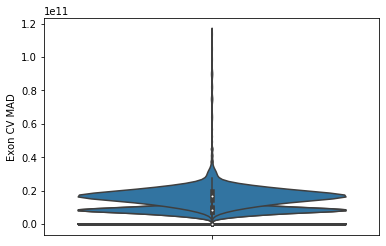

In [83]:
for val in qcs.index:
    boxplot = sns.violinplot(y=qcs.loc[val])

In [92]:
qcs.T.quantile(0.25)

Sample
Mapping Rate                         0.960539
Base Mismatch                        0.003916
End 1 Mapping Rate                   0.963998
End 2 Mapping Rate                   0.957305
End 1 Mismatch Rate                  0.003525
                                       ...   
Median of Avg Transcript Coverage    2.111932
Median of Transcript Coverage Std    2.089405
Median of Transcript Coverage CV     0.873754
Median Exon CV                       0.186166
Exon CV MAD                          0.184010
Name: 0.25, Length: 67, dtype: float64

In [96]:
outlier_bottom_lim

Sample
Mapping Rate                         0.693539
Base Mismatch                       -0.014161
End 1 Mapping Rate                   0.690003
End 2 Mapping Rate                   0.700932
End 1 Mismatch Rate                 -0.012108
                                       ...   
Median of Avg Transcript Coverage   -7.096308
Median of Transcript Coverage Std   -3.922074
Median of Transcript Coverage CV     0.298358
Median Exon CV                      -0.032299
Exon CV MAD                         -0.033237
Length: 67, dtype: float64

In [107]:
for k,v in qc[(qc<outlier_bottom_lim) | (qc>outlier_top_lim)].iteritems():
    print(k)

CDS-12DTEw
CDS-9hv1zM
CDS-B1ywOH
CDS-KMhiT9
CDS-M6mnMA


In [114]:
q1

0.1629766

In [117]:
q3

0.29378590000000004

In [116]:
outlier_bottom_lim

-0.03323735000000008

In [127]:
qcs = qcs.T

In [4]:
tot = []
a = qcs[(qcs["Mapping Rate"] <0.8) | (qcs["Base Mismatch"] >0.02) | (qcs["End 1 Mapping Rate"] <0.75) | (qcs["End 2 Mapping Rate"] <0.75) | (qcs["End 1 Mismatch Rate"] >0.025) | (qcs["End 2 Mismatch Rate"] >0.025) | (qcs["Expression Profiling Efficiency"] <0.6) | (qcs["High Quality Rate"] <0.75) | (qcs["Exonic Rate"] <0.75) | (qcs["Ambiguous Alignment Rate"] >0.08) | (qcs["Avg. Splits per Read"] <0.1) | (qcs["Alternative Alignments"]  >300000000) | (qcs["Chimeric Alignment Rate"] >0.02) | (qcs["Total Reads"] <2000000) | (qcs["Read Length"] <80) | (35000 < qcs["Genes Detected"]) |(qcs["Genes Detected"] < 10000) | (qcs["Mean 3' bias"] >0.8)].index.tolist()
tot.append([1 if i in qcs[(qcs["Mapping Rate"] <0.8)].index.tolist() else 0 for i in a])
tot.append([1 if i in qcs[(qcs["Base Mismatch"] >0.02)].index.tolist() else 0 for i in a])
tot.append([1 if i in qcs[(qcs["End 1 Mapping Rate"] <0.75)].index.tolist() else 0 for i in a])
tot.append([1 if i in qcs[(qcs["End 2 Mapping Rate"] <0.75)].index.tolist() else 0 for i in a])
tot.append([1 if i in qcs[(qcs["End 1 Mismatch Rate"] >0.025)].index.tolist() else 0 for i in a])
tot.append([1 if i in qcs[(qcs["End 2 Mismatch Rate"] >0.025)].index.tolist() else 0 for i in a])
tot.append([1 if i in qcs[(qcs["Expression Profiling Efficiency"] <0.6)].index.tolist() else 0 for i in a])
tot.append([1 if i in qcs[(qcs["High Quality Rate"] <0.75)].index.tolist() else 0 for i in a])
tot.append([1 if i in qcs[(qcs["Exonic Rate"] <0.75)].index.tolist() else 0 for i in a])
tot.append([1 if i in qcs[(qcs["Ambiguous Alignment Rate"] >0.08)].index.tolist() else 0 for i in a])
tot.append([1 if i in qcs[(qcs["Avg. Splits per Read"] <0.1)].index.tolist() else 0 for i in a])
tot.append([1 if i in qcs[(qcs["Alternative Alignments"]>300000000)].index.tolist() else 0 for i in a])
tot.append([1 if i in qcs[(qcs["Chimeric Alignment Rate"] >0.02)].index.tolist() else 0 for i in a])
tot.append([1 if i in qcs[(qcs["Total Reads"] <2000000)].index.tolist() else 0 for i in a])
tot.append([1 if i in qcs[(qcs["Read Length"] <80)].index.tolist() else 0 for i in a])
tot.append([1 if i in qcs[(35000 < qcs["Genes Detected"])].index.tolist() else 0 for i in a])
tot.append([1 if i in qcs[(qcs["Genes Detected"] < 10000)].index.tolist() else 0 for i in a])
tot.append([1 if i in qcs[(qcs["Mean 3' bias"] >0.8)].index.tolist() else 0 for i in a])

NameError: name 'qcs' is not defined

In [3]:
res = pd.DataFrame(index=a,columns=["Mapping Rate",
"Base Mismatch",
"End 1 Mapping Rate",
"End 2 Mapping Rate",
"End 1 Mismatch Rate",
"End 2 Mismatch Rate",
"Expression Profiling Efficiency",
"High Quality Rate",
"Exonic Rate",
"Ambiguous Alignment Efficiency",
"Avg. Splits per Read",
"Alternative Alignments",
"Chimeric Alignment Rate",
"Total Reads",
"Read Length",
"Genes Detected",
"Genes Detected",
"Mean 3' bias"], data=np.array(tot).astype(bool).T)

NameError: name 'a' is not defined

In [ ]:
# I think you can drop End 1/2 metrics. The overall is sufficient to look at them. 

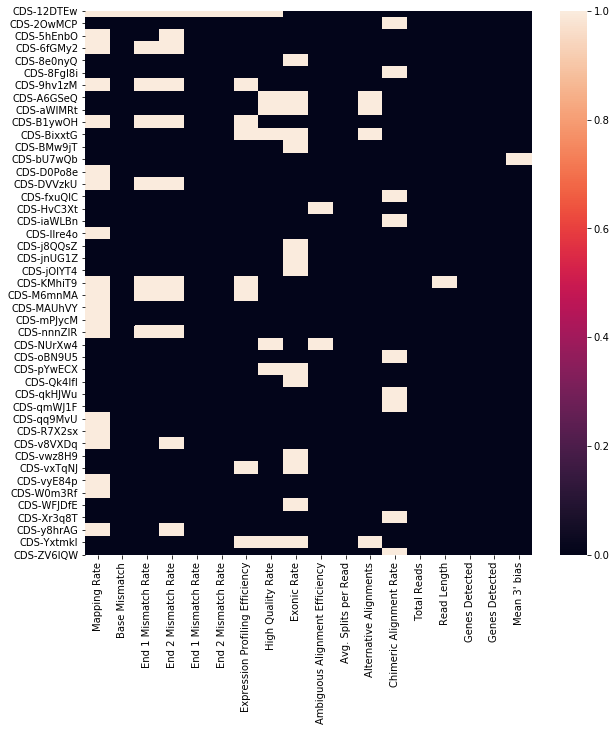

In [150]:
_, ax = plt.subplots(figsize=(10,10))
sns.heatmap(res,ax=ax)

In [136]:
qcs[(qcs["Mapping Rate"] <0.8) | (qcs["Base Mismatch"] >0.02) | (qcs["End 1 Mapping Rate"] <0.75) | (qcs["End 2 Mapping Rate"] <0.75) | (qcs["End 1 Mismatch Rate"] >0.025) | (qcs["End 2 Mismatch Rate"] >0.025) | (qcs["Expression Profiling Efficiency"] <0.6) | (qcs["High Quality Rate"] <0.75) | (qcs["Exonic Rate"] <0.75) | (qcs["Ambiguous Alignment Rate"] >0.08) | (qcs["Avg. Splits per Read"] <0.1) | (qcs["Alternative Alignments"]  >300000000) | (qcs["Chimeric Alignment Rate"] >0.02) | (qcs["Total Reads"] <2000000) | (qcs["Read Length"] <80) | (35000 < qcs["Genes Detected"]) |(qcs["Genes Detected"] < 10000) | (qcs["Mean 3' bias"] >0.8)]

Sample,Mapping Rate,Base Mismatch,End 1 Mapping Rate,End 2 Mapping Rate,End 1 Mismatch Rate,End 2 Mismatch Rate,Expression Profiling Efficiency,High Quality Rate,Exonic Rate,Intronic Rate,...,Median 3' bias,3' bias Std,3' bias MAD_Std,"3' Bias, 25th Percentile","3' Bias, 75th Percentile",Median of Avg Transcript Coverage,Median of Transcript Coverage Std,Median of Transcript Coverage CV,Median Exon CV,Exon CV MAD
CDS-12DTEw,0.581810,0.028087,0.586146,0.577473,0.026458,0.029741,0.483184,0.698056,0.830485,0.060026,...,0.363636,0.307842,0.353802,0.156863,0.670113,4.924890,4.32958,1.037550,0.267371,0.267851
CDS-2OwMCP,0.988123,0.001902,0.991285,0.984962,0.001882,0.001922,0.868307,0.909450,0.878744,0.062888,...,0.727273,0.290764,0.316206,0.437500,0.910256,4.972790,6.12698,1.123960,0.306839,0.307796
CDS-5hEnbO,0.752559,0.013140,0.758985,0.746133,0.011308,0.015003,0.661577,0.875047,0.879103,0.067889,...,0.357143,0.300080,0.348695,0.157895,0.660714,3.180540,2.55897,0.951497,0.207818,0.209997
CDS-6fGMy2,0.719799,0.007684,0.725952,0.713647,0.005522,0.009882,0.636029,0.905015,0.883620,0.066995,...,0.432432,0.294113,0.354169,0.210581,0.700000,2.583890,2.29579,0.925989,0.197655,0.196762
CDS-8e0nyQ,0.957521,0.007137,0.960343,0.954699,0.006494,0.007785,0.713410,0.895753,0.745059,0.172445,...,0.427025,0.290944,0.355293,0.203390,0.694524,4.139580,2.99281,0.827708,0.213093,0.210767
CDS-8Fgl8i,0.976059,0.004969,0.981779,0.970339,0.004138,0.005809,0.906858,0.904240,0.929102,0.037824,...,0.534377,0.294075,0.356209,0.285714,0.764706,3.106610,2.57588,0.879216,0.155314,0.154884
CDS-9hv1zM,0.651495,0.006711,0.647166,0.655824,0.005635,0.007773,0.530546,0.895788,0.814351,0.112433,...,0.432432,0.286847,0.344604,0.223529,0.692308,4.235820,3.42181,0.881494,0.212045,0.209093
CDS-A6GSeQ,0.942180,0.004321,0.947067,0.937292,0.003685,0.004963,0.633970,0.657860,0.672876,0.117064,...,0.598214,0.297949,0.371698,0.323944,0.833333,0.664943,1.01194,1.065270,0.219489,0.220142
CDS-aWlMRt,0.987611,0.001908,0.990458,0.984764,0.001952,0.001863,0.676386,0.718185,0.684871,0.117299,...,0.833333,0.281709,0.207245,0.555556,0.946524,3.194310,4.02624,1.390010,0.366660,0.354832
CDS-B1ywOH,0.561449,0.008801,0.571555,0.551343,0.005910,0.011798,0.497107,0.895094,0.885400,0.069339,...,0.423077,0.296901,0.361146,0.203191,0.705882,2.181000,1.94952,0.936102,0.215808,0.213497


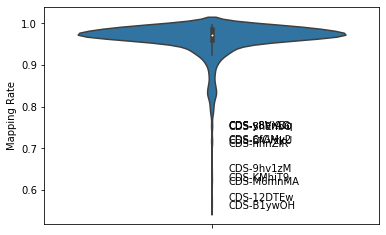

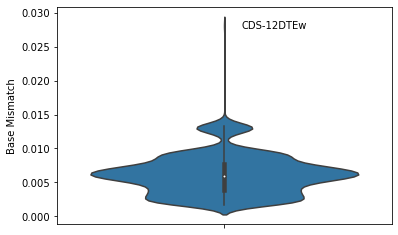

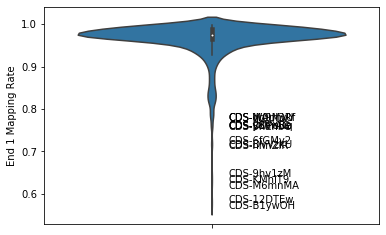

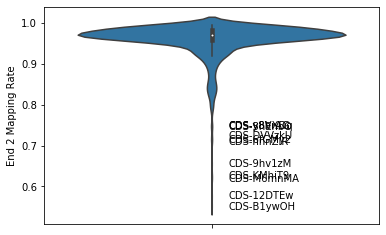

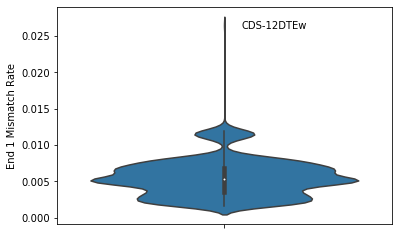

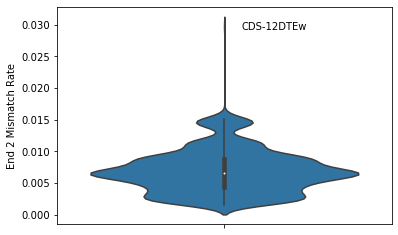

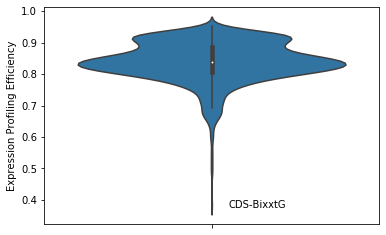

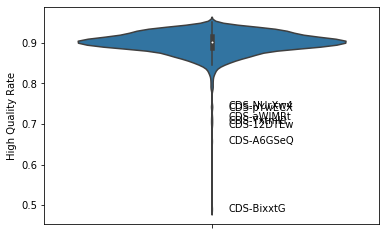

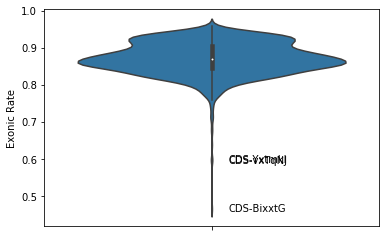

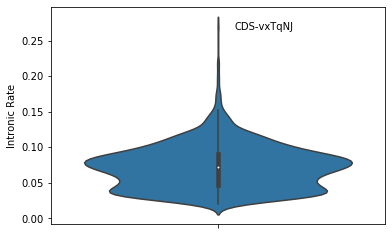

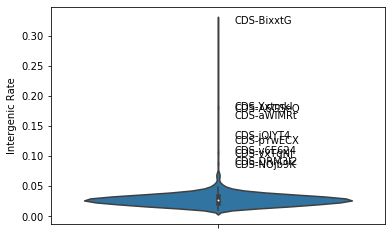

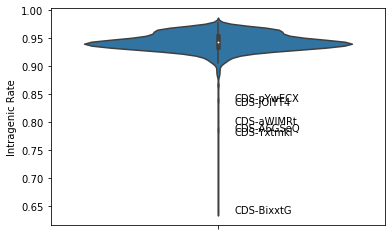

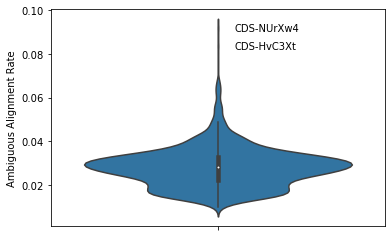

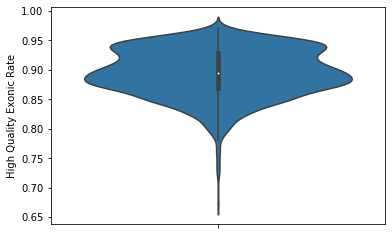

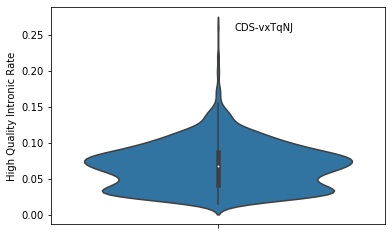

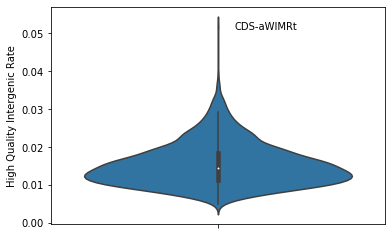

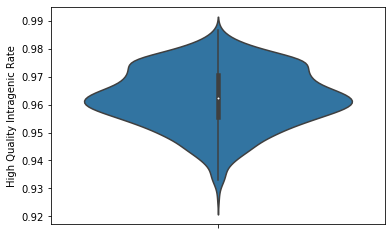

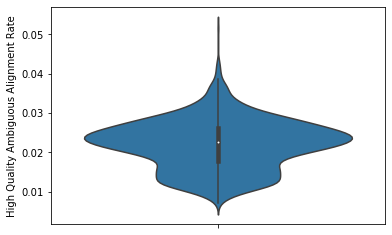

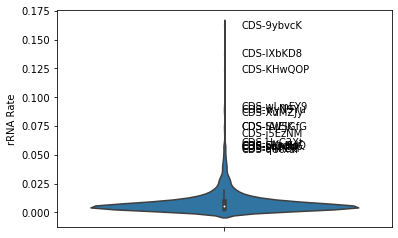

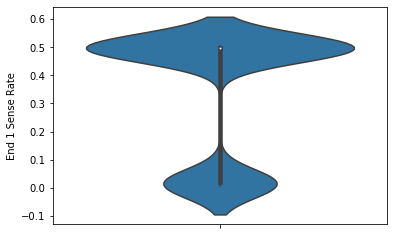

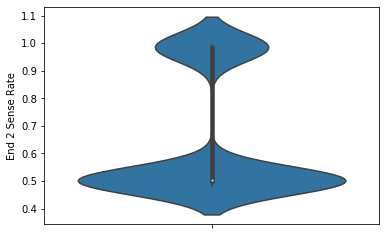

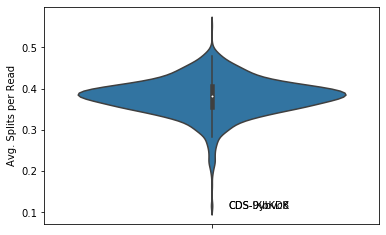

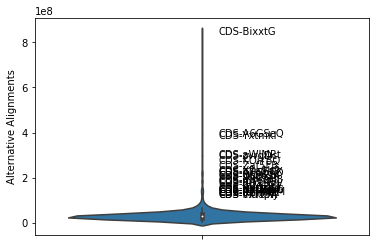

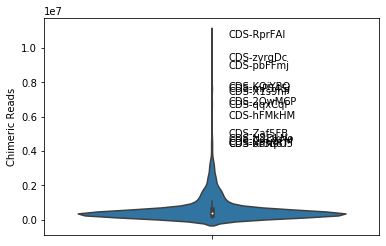

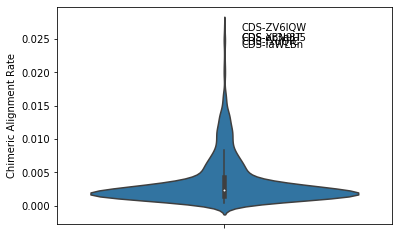

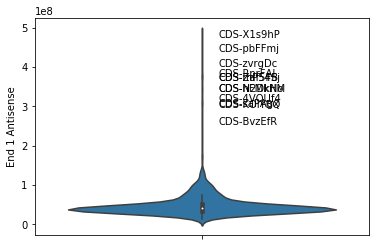

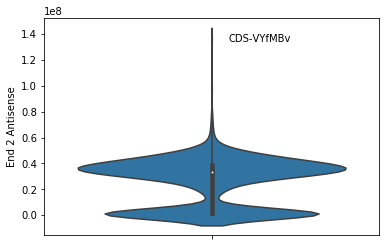

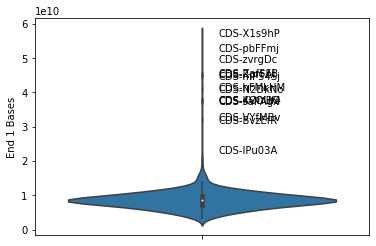

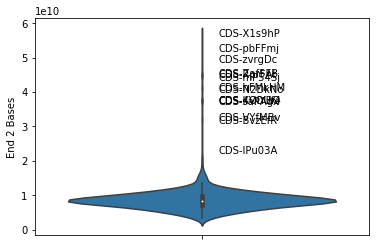

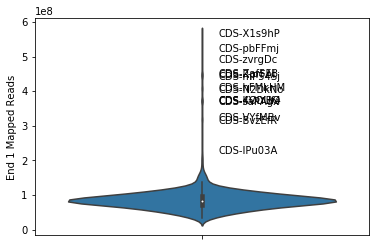

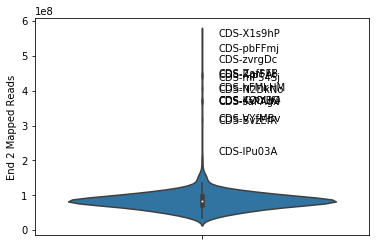

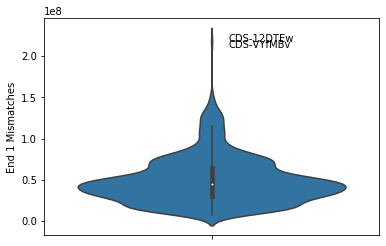

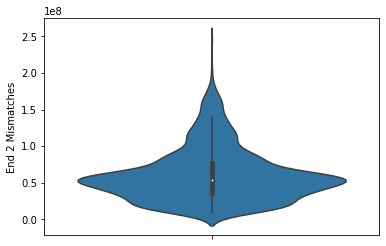

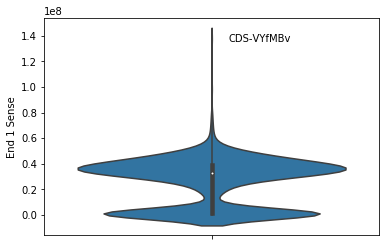

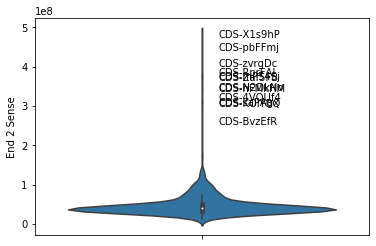

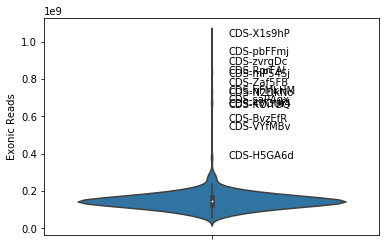

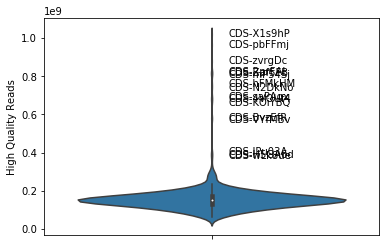

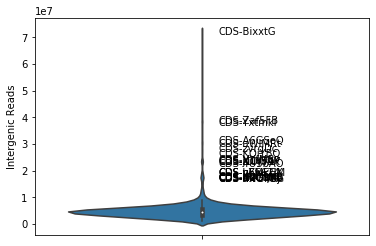

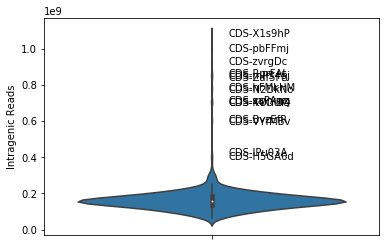

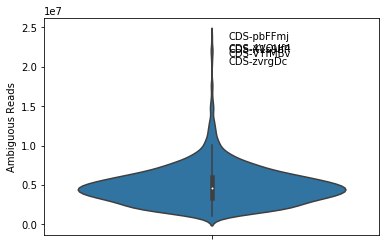

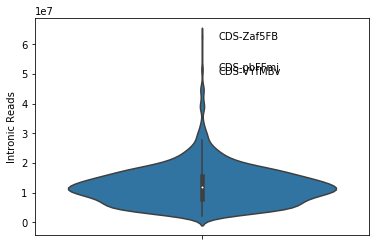

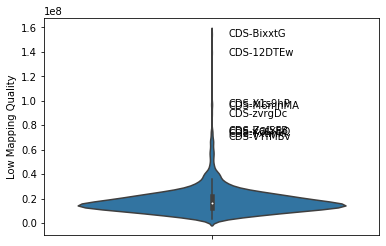

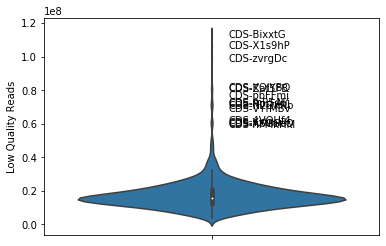

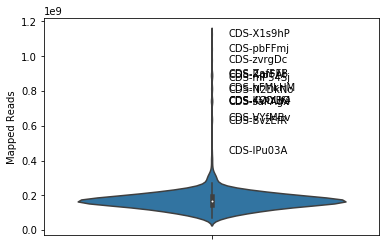

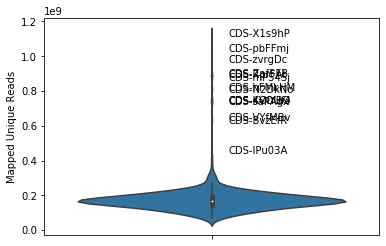

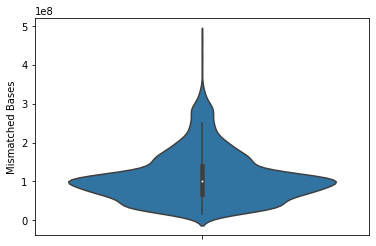

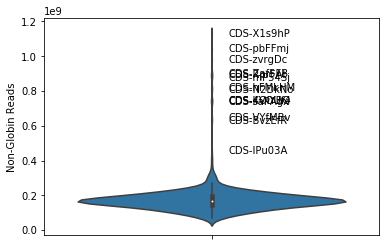

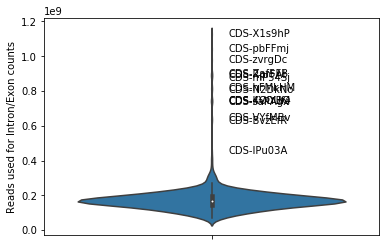

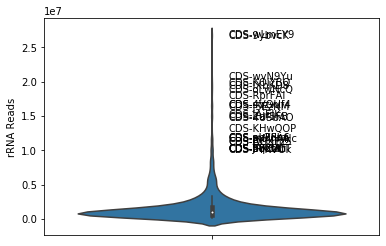

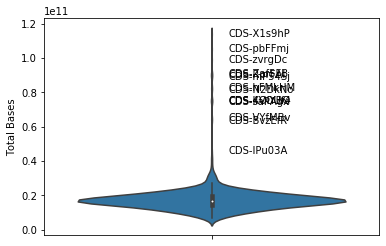

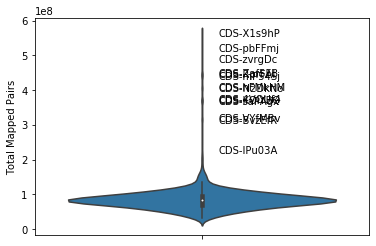

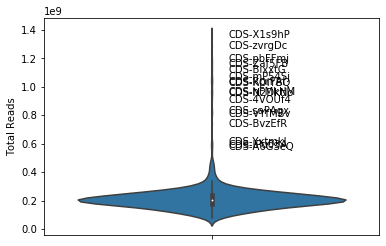

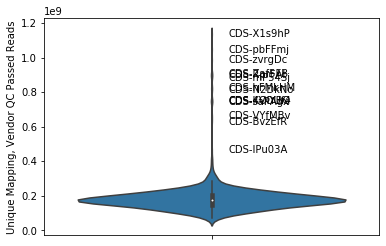

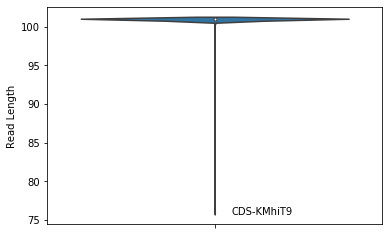

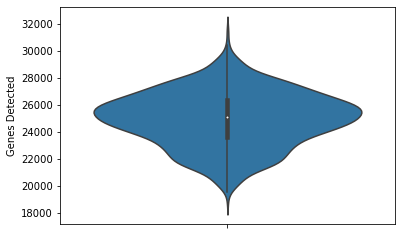

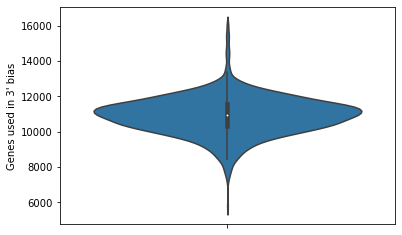

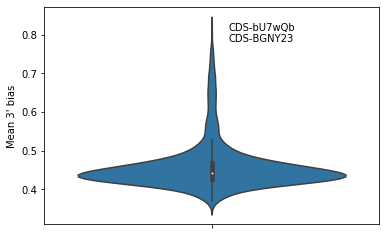

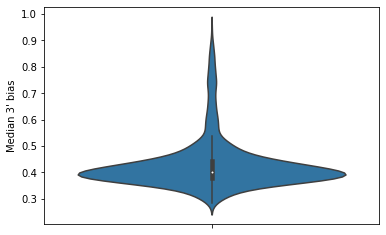

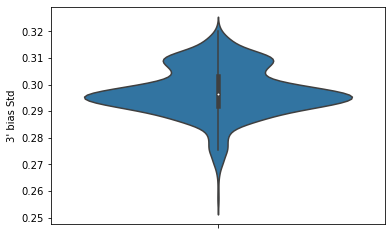

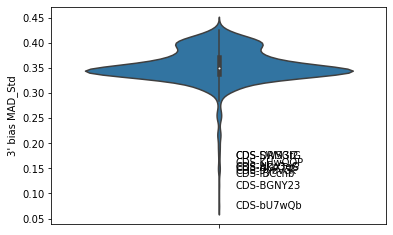

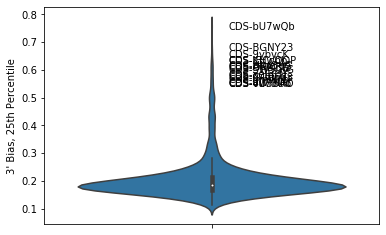

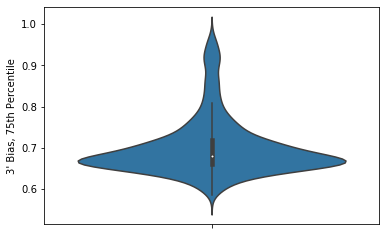

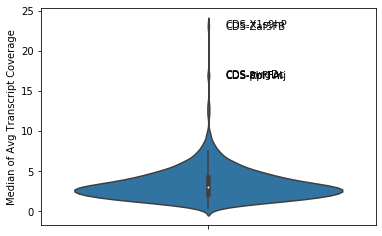

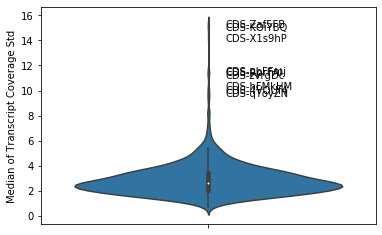

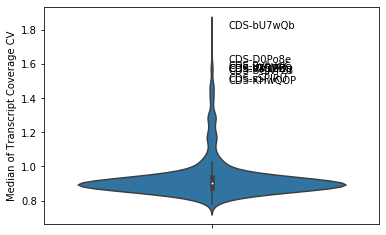

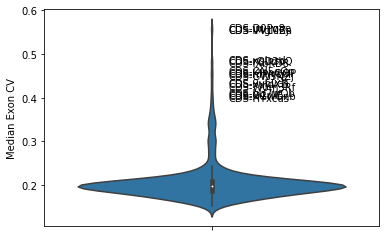

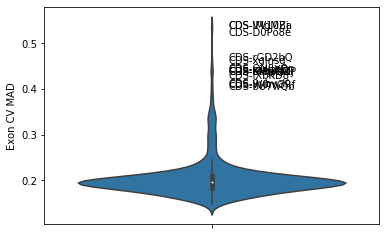

In [124]:
for val in qcs.index:
    qc = qcs.loc[val]
    boxplot = sns.violinplot(y=qc)
    q1 = qc.quantile(0.07)
    q3 = qc.quantile(0.93)
    outlier_top_lim = q3 + 1.5 * (q3 - q1)
    outlier_bottom_lim = q1 - 1.5 * (q3 - q1)
    for k,v in qc[(qc<outlier_bottom_lim) | (qc>outlier_top_lim)].iteritems():
        plt.text(0.05, v,k, ha='left', va='center')
    plt.show()

In [ ]:
new_ref = pd.read_csv('temp/newrefWES.csv',index_col="cds_sample_id")
for k,v in starlogs.items():
    if k =='nan':
        continue
    new_ref.loc[k,'bam_qc']=v+" "+rnaqc[k]
new_ref.to_csv('temp/newrefAll.csv')

### Remove some datafile to save money

In [ ]:
colstoremove = ['fastq1', 'fastq2', 'star_chimeric_bam_file','star_chimeric_bam_index', 'star_transcriptome_bam','recalibrated_bam','recalibrated_bam_index']
for val in colstoremove:
    refwm.disable_hound().delete_entity_attributes('sample', res[val], delete_files=True)

In [ ]:
res.iloc[1]['star_bam_file']

In [ ]:
## copy star bam file to our cclebams/rnasq_hg38/ bucket
renamed, _ = terra.changeGSlocation(workspacefrom=refworkspace, newgs="gs://cclebams/rnasq_hg38/", onlycol=["star_bam_file",'star_bam_index'], entity="sample", keeppath=False,dry_run=False)

In [ ]:
renamed

### Expression post processing

Here we get all data and remove the duplicates directly with the function `removeDuplicates`

we then run:

- readTranscripts
- readCounts
- readTPM
- renameFunction

- Allie's gene renaming / filtering and log transform

In [7]:
res = refwm.get_sample_sets().loc['All_samples']
rsem_genes_expected_count = res['rsem_genes_expected_count']
rsem_genes_tpm = res['rsem_genes_tpm']
rsem_transcripts_tpm = res['rsem_transcripts_tpm']
rsem_transcripts_expected_count = res['rsem_transcripts_expected_count']
! gsutil cp $rsem_genes_expected_count "temp/rsem_genes_expected_count" & gsutil cp $rsem_genes_tpm "temp/rsem_genes_tpm" & gsutil cp $rsem_transcripts_tpm "temp/rsem_transcripts_tpm" & gsutil cp $rsem_transcripts_expected_count "temp/rsem_transcripts_expected_count"

Copying gs://fc-secure-639c94ba-2b0d-4960-92fc-9cd50046a968/751d1b66-5603-4056-a153-4570f01bc8d8/rsem_aggregate_results_workflow/b70ffcaf-b16e-4663-a64b-e87ddcba2605/call-rsem_aggregate_results/Aggregate_Fusion_Calls_2020-04-22T17-55-36.rsem_transcripts_tpm.txt.gz...
Copying gs://fc-secure-639c94ba-2b0d-4960-92fc-9cd50046a968/751d1b66-5603-4056-a153-4570f01bc8d8/rsem_aggregate_results_workflow/b70ffcaf-b16e-4663-a64b-e87ddcba2605/call-rsem_aggregate_results/Aggregate_Fusion_Calls_2020-04-22T17-55-36.rsem_genes_tpm.txt.gz...
Copying gs://fc-secure-639c94ba-2b0d-4960-92fc-9cd50046a968/751d1b66-5603-4056-a153-4570f01bc8d8/rsem_aggregate_results_workflow/b70ffcaf-b16e-4663-a64b-e87ddcba2605/call-rsem_aggregate_results/Aggregate_Fusion_Calls_2020-04-22T17-55-36.rsem_genes_expected_count.txt.gz...
\ [1 files][ 77.9 MiB/ 77.9 MiB]                                                
Operation completed over 1 objects/77.9 MiB.                                     
\ [1 files][ 74.7 MiB/ 74.7 MiB]  

In [8]:
files = {}
for val in ["temp/rsem_transcripts_tpm","temp/rsem_genes_tpm","temp/rsem_genes_expected_count","temp/rsem_transcripts_expected_count"]:
    file = pd.read_csv(val, compression='gzip', header=0, sep='\t', quotechar='"', error_bad_lines=False)
    print(file.columns[:10])
    renaming,_ = removeOlderVersions(names=file.columns[2:], refsamples=refwm.get_samples(), arxspan_id="arxspan_id", version="version")
    renaming.update({'transcript_id(s)','transcript'})
    files[val.split('/')[1]] = file[file.columns[:2].tolist()+[i for i in file.columns if i in renaming.keys()]].rename(columns=renaming)

Index(['gene_id', 'transcript_id(s)', 'CDS-010xbm', 'CDS-02TzJp', 'CDS-0693hw',
       'CDS-07Plat', 'CDS-0BNTL7', 'CDS-0CqPRM', 'CDS-0EOjym', 'CDS-0Jkjew'],
      dtype='object')
removed 65 duplicate samples
Index(['transcript_id', 'gene_id', 'CDS-010xbm', 'CDS-02TzJp', 'CDS-0693hw',
       'CDS-07Plat', 'CDS-0BNTL7', 'CDS-0CqPRM', 'CDS-0EOjym', 'CDS-0Jkjew'],
      dtype='object')
removed 65 duplicate samples
Index(['gene_id', 'transcript_id(s)', 'CDS-010xbm', 'CDS-02TzJp', 'CDS-0693hw',
       'CDS-07Plat', 'CDS-0BNTL7', 'CDS-0CqPRM', 'CDS-0EOjym', 'CDS-0Jkjew'],
      dtype='object')
removed 65 duplicate samples


#### saving samples used for the release

In [ ]:
new_ref.loc[renaming.keys(),release]=1
new_ref.to_csv('temp/newrefAll.csv')

In [ ]:
#plot non zero readccounts across all samples and showing extremas
zero_max = 39000
zero_min = 5000

zeroloc= files['rsem_genes_expected_count'][files['rsem_genes_expected_count']==0].sum(1)
boxplot = sns.kdeplot(y=zeroloc)

for k,v in zeroloc[(zeroloc<zero_min) | (qc>zero_max)].iteritems():
    plt.text(0.05, v,k, ha='left', va='center')
plt.show()

In [ ]:
#find duplicate genes
print(h.dups(files['rsem_genes_expected_count']['gene_id']))
print(h.dups(files['rsem_genes_tpm']['gene_id']))

In [ ]:
gencode_v29_annotation = tc.download_to_cache(name='gene-annotations-e737', version=1, file='gencode.v29.annotation')  # download_to_cache for raw

tpm_protein_coding <- prepare_depmap_TPM_for_taiga(tpm_genes, log_transform=T, just_protein_coding=T, gencode_annotations=annotations)
tpm_genes <- prepare_depmap_TPM_for_taiga(tpm_genes, log_transform=T, just_protein_coding=F, gencode_annotations=annotations)

In [ ]:
hgnc_complete_set = tc.get(name='hgnc-87ab', file='hgnc_complete_set')
! wget $gencode temp/
gencode_data = gff3.read("temp/"+gencode.split('/')[-1])
gencode_data['gene_id'] = [i.replace('\\..*','') for i in gencode_data['gene_id']]
gencode_data = gencode_data.drop_duplicates('gene_id')[["gene_id", "gene_name","transcript_id"]].rename({"gene_id":"ensembl_gene_id","gene_name":'hgnc_id'})
gencode_data[gencode_data['transcript_id'].isna()]

In [ ]:

  row_metadata <- rnaseq_data %>% 
    dplyr::select(gene_id, `transcript_id(s)`) %>%
    dplyr::mutate(ensembl_gene_id=gsub("\\..*", "", gene_id)) %>% as.data.frame(.)
  
  rownames(row_metadata) <- row_metadata$ensembl_gene_id
  rownames(gene_map) <- gene_map$ensembl_gene_id
  
  intersect_genes <- row_metadata$ensembl_gene_id %in% gene_map$ensembl_gene_id
  row_metadata <- row_metadata[intersect_genes,]
  
  rnaseq_data <- rnaseq_data[intersect_genes,]
  gene_map <- gene_map[row_metadata$ensembl_gene_id,]
  
  if((nrow(gene_map)!=nrow(row_metadata)) & length(which(gene_map$ensembl_gene_id == row_metadata$ensembl_gene_id)) != nrow(row_metadata)) {
    print("ERROR! Incorrectly pairing gene names")
  }
  row_metadata$HGNC_symbol <- gene_map$hgnc_id
  row_metadata$concat_gene_name <- paste0(row_metadata$HGNC_symbol, " (", row_metadata$ensembl_gene_id, ")")
   
  data_matrix <- rnaseq_data %>% 
    dplyr::select(-gene_id, -`transcript_id(s)`) %>%
    as.matrix() %>%
    magrittr::set_rownames(row_metadata[["concat_gene_name"]]) %>%
    t() 
  
  if(log_transform) {
    data_matrix <- log2(data_matrix + 1)
  }
  
  # broad_ids <- gsub(".*\\((.*)\\).*", "\\1", rownames(data_matrix))
  # 
  # data_matrix <- data_matrix %>%
  #   magrittr::set_rownames(broad_ids)  
  
  if(just_protein_coding) {
      hgnc_gene_dataset <- taigr::load.from.taiga(data.name='hgnc-87ab', data.version=3, data.file='hgnc_complete_set-2018q3')
      pc_genes <- protein_coding_genes(row_metadata, hgnc_gene_dataset)
      pc_genes <- pc_genes %>%
        dplyr::mutate(concat_entrez_ID=paste0(symbol,
                                              " (",
                                              gsub("[.].*", "", entrez_id),
                                              ")"))
      if(length(unique(pc_genes$symbol)) < nrow(pc_genes)) {
        print("ERROR! HGNC symbols not unique")
      }
      
      print(paste("using", nrow(pc_genes), "protein coding genes"))
    data_matrix <- data_matrix[,pc_genes$concat_gene_name] %>% 
      magrittr::set_colnames(pc_genes$concat_entrez_ID)
  }
  return(data_matrix)
}

In [ ]:
ensembl_hgnc_gene_pairing <- function(filename) {
  
  hgnc_gene_dataset <- taigr::load.from.taiga(data.name='hgnc-87ab', data.version=3, data.file='hgnc_complete_set-2018q3')
  #ftp://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_35/gencode.v35.annotation.gff3.gz
#https://pypi.org/project/gff3/
  gencode_gene_data <- rtracklayer::readGFF(filename, tags=c("gene_id", "gene_name", "transcript_id"))
  
  gencode_gene_data$gene_id <- gsub("\\..*", "", gencode_gene_data$gene_id)
  remove_id <- which(duplicated(gencode_gene_data$gene_id)==T)
  gencode_gene_data <- gencode_gene_data[-remove_id,]
  gencode_gene_data <- gencode_gene_data[,c("gene_id", "gene_name")]
  colnames(gencode_gene_data) <- c("ensembl_gene_id", "hgnc_id")
  
  gencode_gene_data <- plyr::join(gencode_gene_data, hgnc_gene_dataset[,c('symbol', 'ensembl_gene_id', 'locus_group', 'entrez_id')], by='ensembl_gene_id', type='left')
  gencode_gene_data$old_symbol <- gencode_gene_data$hgnc_id
  
  gencode_gene_data[which(!is.na(gencode_gene_data$symbol)), 'hgnc_id'] <- gencode_gene_data$symbol[which(!is.na(gencode_gene_data$symbol))]
  
  duplicated_genes <- which(duplicated(gencode_gene_data$ensembl_gene_id)==T)
  if(length(duplicated_genes) > 0) {
    print(paste(length(duplicated_genes), "duplicated ensembl ID(s)!"))
    gencode_gene_data <- gencode_gene_data[-duplicated_genes,]
  }
  return(gencode_gene_data)
}

In [ ]:
prepare_depmap_transcripts_for_taiga <- function(rnaseq_data, 
                                         gencode_annotations = "~/data_files/gene_annotations/gencode.v19.annotation.gtf"){
  
  require(magrittr)
  

  row_metadata <- rnaseq_data %>% 
    dplyr::select(gene_id, `transcript_id`) %>%
    dplyr::mutate(transcript_id=gsub("\\..*", "", `transcript_id`)) %>% as.data.frame(.)
  
  rownames(row_metadata) <- row_metadata$transcript_id
  rownames(gene_map) <- gene_map$transcript_id
  
  intersect_genes <- row_metadata$transcript_id %in% gene_map$transcript_id
  row_metadata <- row_metadata[intersect_genes,]
  
  rnaseq_data <- rnaseq_data[intersect_genes,]
  gene_map <- gene_map[row_metadata$transcript_id,]
  
  if((nrow(gene_map)!=nrow(row_metadata)) & length(which(gene_map$transcript_id == row_metadata$transcript_id)) != nrow(row_metadata)) {
    print("ERROR! Incorrectly pairing gene names")
  }
  
  row_metadata$HGNC_symbol <- gene_map$gene_name
  row_metadata$concat_gene_name <- paste0(row_metadata$HGNC_symbol, " (", row_metadata$transcript_id, ")")
  
  data_matrix <- rnaseq_data %>% 
    dplyr::select(-gene_id, -`transcript_id`) %>%
    as.matrix() %>%
    magrittr::set_rownames(row_metadata[["concat_gene_name"]]) %>%
    t() 
  
  return(data_matrix)
  
}

In [ ]:
%%R
### transcripts
library('cdsomics')
print(colnames(tpm_transcripts)[1:10])
tpm_transcript_id <- gsub("\\..*", "", tpm_transcripts$`transcript_id`)
if(nrow(tpm_transcripts) != length(unique(tpm_transcript_id))) {
  print("Duplicated transcript ids")
  print(nrow(tpm_transcripts) - length(unique(tpm_transcript_id)))
  tpm_transcript <- tpm_transcripts[-which(duplicated(tpm_transcript_id)==T),]
}
tpm_transcripts <- prepare_depmap_transcripts_for_taiga(tpm_transcript, gencode_annotations = annotations) 

In [ ]:
%%R
### counts
print(colnames(counts_genes)[1:10])
counts_gene_ids <- gsub("\\..*", "", counts_genes$gene_id)
if(nrow(counts_genes) != length(unique(counts_gene_ids))) {
  print("Duplicate ensembl ids")
  print(length(which(duplicated(counts_gene_ids)==T)))
  counts_genes <- counts_genes[-which(duplicated(counts_gene_ids)==T),]
}
counts_genes <- prepare_depmap_TPM_for_taiga(counts_genes, gencode_annotations =annotations) 

## ssGSEA

In [207]:
counts_genes.columns = [i.split(' (')[0] for i in counts_genes.columns]

In [208]:
len(set([val.split('.')[0] for val in counts_genes.columns if '.' in val]))

10910

In [255]:
#### merging splicing variants into the same gene
counts_genes_merged= mergeSplicingVariants(counts_genes.T,defined='.')

15%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



18%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



34%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



41%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



45%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



53%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



57%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



65%61%62%63%64%65%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



69%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



74%73%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



86%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [260]:
counts_genes_merged = counts_genes_merged[counts_genes_merged.sum(1)!=0]

In [262]:
counts_genes_merged = counts_genes_merged[counts_genes_merged.var(1)!=0]

In [309]:
counts_genes_merged.shape

(43920, 1419)

### with R ssGSEA on the console

In [288]:
counts_genes_merged.to_csv("temp/for_ssGSEA.csv")

In [307]:
! Rscript src/ssGSEA.R temp/for_ssGSEA.csv data/genesets/ALL.gmt

Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min

Loading required package: Biobase
Welcome to Bioconductor

    Vignettes contain introductory material; view with


In [311]:
counts_genes_merged.columns

Index(['ACH-000001', 'ACH-000002', 'ACH-000003', 'ACH-000004', 'ACH-000005',
       'ACH-000006', 'ACH-000007', 'ACH-000008', 'ACH-000009', 'ACH-000010',
       ...
       'ACH-002466', 'ACH-002467', 'ACH-002475', 'ACH-002476', 'ACH-002508',
       'ACH-002509', 'ACH-002510', 'ACH-002511', 'ACH-002512', 'ACH-002709'],
      dtype='object', length=1419)

In [314]:
enrichments = pd.read_csv('temp/res_ssGSEA.csv', names = ['genesets']+counts_genes_merged.columns.tolist(), skiprows=1)

/home/jeremie/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [315]:
enrichments

,genesets,ACH-000001,ACH-000002,ACH-000003,ACH-000004,ACH-000005,ACH-000006,ACH-000007,ACH-000008,ACH-000009,...,ACH-002466,ACH-002467,ACH-002475,ACH-002476,ACH-002508,ACH-002509,ACH-002510,ACH-002511,ACH-002512,ACH-002709
0,BCL6-HDAC4 complex (human),0.293305995354723,0.350357167438919,0.281429523137695,0.201094498283284,0.214758750180599,0.339174365720212,0.310369374432119,0.362799983059709,0.301929327832743,...,0.320177,0.299276,0.291794,0.296885,0.342425,0.355362,0.318377,0.433182,0.365020,0.233581
1,BCL6-HDAC5 complex (human),0.332034956498777,0.331908234938897,0.349560682805384,0.262719812097931,0.243300591702866,0.34715384595502,0.310251440555441,0.362049834857558,0.324154438812801,...,0.360339,0.352074,0.334934,0.342438,0.374843,0.413109,0.345727,0.410312,0.368677,0.306243
2,BCL6-HDAC7 complex (human),0.400636472991267,0.318616750667592,0.375513455254736,0.288691223121843,0.291513923457807,0.345355523170326,0.331071192438336,0.392828224986183,0.382474530153264,...,0.401419,0.385454,0.331406,0.334280,0.418218,0.385026,0.330653,0.442043,0.385808,0.315565
3,Multisubunit ACTR coactivator complex (human),0.407674314913682,0.364012870866344,0.416576516292431,0.399925717600606,0.414911520673675,0.4214033112682,0.377441803941928,0.43758734473403,0.425678710557321,...,0.396856,0.398061,0.409871,0.395969,0.425656,0.414760,0.427878,0.469069,0.435955,0.421185
4,6S-nuclear aryl hydrocarbon (Ah) receptor liga...,0.351824677228457,0.337392494671042,0.39226132649506,0.344500400008425,0.366732671765925,0.436051104286491,0.383207934507988,0.406540820613829,0.398507650137845,...,0.429850,0.439439,0.343833,0.321416,0.448832,0.421351,0.419637,0.469993,0.436434,0.406292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10100,NFIA (human),0.21858,0.202776,0.219514,0.205975,0.20077,0.199807,0.211043,0.207803,0.212205,...,0.163386,0.163807,0.182932,0.182521,0.182468,0.212763,0.173287,0.195479,0.192793,0.171498
10101,IRF7 (human),0.288494,0.265948,0.296564,0.261968,0.270008,0.264314,0.280514,0.280543,0.293903,...,0.246003,0.248702,0.270923,0.269356,0.269161,0.282811,0.251404,0.252008,0.281758,0.248047
10102,HOXD9 (human),0.257192,0.232722,0.257908,0.23907,0.249277,0.230837,0.235909,0.252158,0.251952,...,0.222397,0.225256,0.248851,0.245608,0.232285,0.254022,0.236470,0.251595,0.251936,0.211296
10103,PBX1 (human),0.234739,0.218925,0.258101,0.252296,0.246162,0.236354,0.225457,0.228218,0.227833,...,0.176305,0.169113,0.195242,0.183492,0.184864,0.217014,0.197341,0.228764,0.211057,0.224004


### with GSEApy

In [ ]:
genesets = ["GO_Biological_Process_2015", "GO_Cellular_Component_2015", "GO_Molecular_Function_2015", "Reactome_2013", "BioCarta_2013", "KEGG_2016", "CORUM", "TRANSFAC_and_JASPAR_PWMs", "Chromosome_Location","data/genesets/oncogenic.gmt",
"data/genesets/positional.gmt","data/genesets/hallmark.gmt", "data/genesets/cancer_modules.gmt"]

In [ ]:
counts_genes_merged['NAME'] = counts_genes_merged.index
counts_genes_merged = counts_genes_merged.drop(columns='genes')

In [ ]:
#for val in genesets:
res = gseapy.ssgsea(data=counts_genes_merged[counts_genes_merged.columns], gene_sets="KEGG_2016",
    outdir='temp/',
    sample_norm_method='rank', # choose 'custom' for your own rank list
    permutation_num=0, # skip permutation procedure, because you don't need it
    no_plot=True, # skip plotting, because you don't need these figures
    processes=8, 
    format='png',
    seed=9)

### with GSVA

In [101]:
! Rscript -e 'install.packages("BiocManager");\
              BiocManager::install(c("GSEABase","GSVA"),dep=TRUE)'
! pip install GSVA

Installing package into ‘/home/jeremie/R/x86_64-pc-linux-gnu-library/3.6’
(as ‘lib’ is unspecified)
trying URL 'https://cloud.r-project.org/src/contrib/BiocManager_1.30.10.tar.gz'
Content type 'application/x-gzip' length 40205 bytes (39 KB)
downloaded 39 KB

* installing *source* package ‘BiocManager’ ...
** package ‘BiocManager’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (BiocManager)

The downloaded source packages are in
	‘/tmp/Rtmp58v802/downloaded_packages’
Bioconductor version 3.9 (BiocManager 1.30.10), R 3.6.1 (2019-07-05)
Installing package(s) 'GSEABase', 'GSVA'
also installing the

Content type 'application/x-gzip' length 13351270 bytes (12.7 MB)
downloaded 12.7 MB

trying URL 'https://bioconductor.org/packages/3.9/bioc/src/contrib/GSEABase_1.46.0.tar.gz'
Content type 'application/x-gzip' length 240269 bytes (234 KB)
downloaded 234 KB

trying URL 'https://bioconductor.org/packages/3.9/bioc/src/contrib/GSVA_1.32.0.tar.gz'
Content type 'application/x-gzip' length 1554886 bytes (1.5 MB)
downloaded 1.5 MB

* installing *source* package ‘dichromat’ ...
** package ‘dichromat’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** data
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (dichromat)
* installing *source* package ‘biomaRt’ ...
** using staged install

                 from cliques.cpp:1:
/home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/include/boost/smart_ptr/detail/shared_count.hpp:356:33: warning: ‘template<class> class std::auto_ptr’ is deprecated [-Wdeprecated-declarations]
     explicit shared_count( std::auto_ptr<Y> & r ): pi_( new sp_counted_impl_p<Y>( r.get() ) )
                                 ^~~~~~~~
In file included from /usr/include/c++/6/memory:81:0,
                 from /home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/include/boost/config/no_tr1/memory.hpp:21,
                 from /home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/include/boost/smart_ptr/shared_ptr.hpp:23,
                 from /home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/include/boost/shared_ptr.hpp:17,
                 from /home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/include/boost/property_map/vector_property_map.hpp:14,
                 from /home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/include/boost/property_map/property_m

In file included from /home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/include/boost/shared_ptr.hpp:17:0,
                 from /home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/include/boost/property_map/vector_property_map.hpp:14,
                 from /home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/include/boost/property_map/property_map.hpp:602,
                 from RBGL.hpp:17,
                 from clusteringCoef.cpp:1:
/home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/include/boost/smart_ptr/shared_ptr.hpp:471:31: warning: ‘template<class> class std::auto_ptr’ is deprecated [-Wdeprecated-declarations]
     explicit shared_ptr( std::auto_ptr<Y> & r ): px(r.get()), pn()
                               ^~~~~~~~
In file included from /usr/include/c++/6/memory:81:0,
                 from /home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/include/boost/config/no_tr1/memory.hpp:21,
                 from /home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/include/boost/smart_ptr/s

                 from /home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/include/boost/property_map/property_map.hpp:602,
                 from RBGL.hpp:17,
                 from dominatorTree.cpp:1:
/usr/include/c++/6/bits/unique_ptr.h:49:28: note: declared here
   template<typename> class auto_ptr;
                            ^~~~~~~~
In file included from /home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/include/boost/shared_ptr.hpp:17:0,
                 from /home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/include/boost/property_map/vector_property_map.hpp:14,
                 from /home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/include/boost/property_map/property_map.hpp:602,
                 from RBGL.hpp:17,
                 from dominatorTree.cpp:1:
/home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/include/boost/smart_ptr/shared_ptr.hpp:567:34: warning: ‘template<class> class std::auto_ptr’ is deprecated [-Wdeprecated-declarations]
     shared_ptr & operator=( std::auto

                 from /home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/include/boost/config/no_tr1/memory.hpp:21,
                 from /home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/include/boost/smart_ptr/shared_ptr.hpp:23,
                 from /home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/include/boost/shared_ptr.hpp:17,
                 from /home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/include/boost/property_map/vector_property_map.hpp:14,
                 from /home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/include/boost/property_map/property_map.hpp:602,
                 from RBGL.hpp:17,
                 from edmonds_optimum_branching.cpp:1:
/usr/include/c++/6/bits/unique_ptr.h:49:28: note: declared here
   template<typename> class auto_ptr;
                            ^~~~~~~~
In file included from /home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/include/boost/shared_ptr.hpp:17:0,
                 from /home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/in

                 from hcs.cpp:1:
/home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/include/boost/smart_ptr/scoped_ptr.hpp: At global scope:
/home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/include/boost/smart_ptr/scoped_ptr.hpp:74:31: warning: ‘template<class> class std::auto_ptr’ is deprecated [-Wdeprecated-declarations]
     explicit scoped_ptr( std::auto_ptr<T> p ) BOOST_SP_NOEXCEPT : px( p.release() )
                               ^~~~~~~~
In file included from /usr/include/c++/6/memory:81:0,
                 from /home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/include/boost/config/no_tr1/memory.hpp:21,
                 from /home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/include/boost/smart_ptr/shared_ptr.hpp:23,
                 from /home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/include/boost/shared_ptr.hpp:17,
                 from /home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/include/boost/property_map/vector_property_map.hpp:14,
                 from /home/

                 from /home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/include/boost/shared_ptr.hpp:17,
                 from /home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/include/boost/property_map/vector_property_map.hpp:14,
                 from /home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/include/boost/property_map/property_map.hpp:602,
                 from RBGL.hpp:17,
                 from interfaces.cpp:1:
/usr/include/c++/6/bits/unique_ptr.h:49:28: note: declared here
   template<typename> class auto_ptr;
                            ^~~~~~~~
In file included from /home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/include/boost/shared_ptr.hpp:17:0,
                 from /home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/include/boost/property_map/vector_property_map.hpp:14,
                 from /home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/include/boost/property_map/property_map.hpp:602,
                 from RBGL.hpp:17,
                 from interfaces.cpp:

In file included from /usr/include/c++/6/memory:81:0,
                 from /home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/include/boost/config/no_tr1/memory.hpp:21,
                 from /home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/include/boost/smart_ptr/shared_ptr.hpp:23,
                 from /home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/include/boost/shared_ptr.hpp:17,
                 from /home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/include/boost/property_map/vector_property_map.hpp:14,
                 from /home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/include/boost/property_map/property_map.hpp:602,
                 from RBGL.hpp:17,
                 from minST.cpp:1:
/usr/include/c++/6/bits/unique_ptr.h:49:28: note: declared here
   template<typename> class auto_ptr;
                            ^~~~~~~~
In file included from /home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/include/boost/shared_ptr.hpp:17:0,
                 from /home/jeremie/R/x86

                 from /home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/include/boost/smart_ptr/shared_ptr.hpp:23,
                 from /home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/include/boost/shared_ptr.hpp:17,
                 from /home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/include/boost/property_map/vector_property_map.hpp:14,
                 from /home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/include/boost/property_map/property_map.hpp:602,
                 from RBGL.hpp:17,
                 from minST.cpp:1:
/usr/include/c++/6/bits/unique_ptr.h:49:28: note: declared here
   template<typename> class auto_ptr;
                            ^~~~~~~~
g++ -std=gnu++11 -I"/usr/share/R/include" -DNDEBUG -I/home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/include  -I"/home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/include"   -fpic  -g -O2 -fdebug-prefix-map=/home/jranke/git/r-backports/stretch/r-base-3.6.1=. -fstack-protector-strong -Wformat -Werror=format-securit

                 from /home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/include/boost/property_map/vector_property_map.hpp:14,
                 from /home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/include/boost/property_map/property_map.hpp:602,
                 from RBGL.hpp:17,
                 from ordering.cpp:1:
/home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/include/boost/smart_ptr/shared_ptr.hpp:256:65: warning: ‘template<class> class std::auto_ptr’ is deprecated [-Wdeprecated-declarations]
 template< class T, class R > struct sp_enable_if_auto_ptr< std::auto_ptr< T >, R >
                                                                 ^~~~~~~~
In file included from /usr/include/c++/6/memory:81:0,
                 from /home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/include/boost/config/no_tr1/memory.hpp:21,
                 from /home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/include/boost/smart_ptr/shared_ptr.hpp:23,
                 from /home/jeremie/R/x86_64-p

                 from ordering.cpp:1:
/home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/include/boost/smart_ptr/shared_ptr.hpp: In member function ‘boost::shared_ptr<T>& boost::shared_ptr<T>::operator=(std::auto_ptr<_Up>&&)’:
/home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/include/boost/smart_ptr/shared_ptr.hpp:578:38: warning: ‘template<class> class std::auto_ptr’ is deprecated [-Wdeprecated-declarations]
         this_type( static_cast< std::auto_ptr<Y> && >( r ) ).swap( *this );
                                      ^~~~~~~~
In file included from /usr/include/c++/6/memory:81:0,
                 from /home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/include/boost/config/no_tr1/memory.hpp:21,
                 from /home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/include/boost/smart_ptr/shared_ptr.hpp:23,
                 from /home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/include/boost/shared_ptr.hpp:17,
                 from /home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/

                 from /home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/include/boost/property_map/property_map.hpp:602,
                 from RBGL.hpp:17,
                 from planar.cpp:1:
/usr/include/c++/6/bits/unique_ptr.h:49:28: note: declared here
   template<typename> class auto_ptr;
                            ^~~~~~~~
In file included from /home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/include/boost/scoped_ptr.hpp:13:0,
                 from /home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/include/boost/graph/adjacency_list.hpp:23,
                 from RBGL.hpp:38,
                 from planar.cpp:1:
/home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/include/boost/smart_ptr/scoped_ptr.hpp: At global scope:
/home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/include/boost/smart_ptr/scoped_ptr.hpp:74:31: warning: ‘template<class> class std::auto_ptr’ is deprecated [-Wdeprecated-declarations]
     explicit scoped_ptr( std::auto_ptr<T> p ) BOOST_SP_NOEXCEPT : px( p.releas

                 from /home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/include/boost/property_map/property_map.hpp:602,
                 from RBGL.hpp:17,
                 from shortestPath.cpp:1:
/home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/include/boost/smart_ptr/detail/shared_count.hpp:356:33: warning: ‘template<class> class std::auto_ptr’ is deprecated [-Wdeprecated-declarations]
     explicit shared_count( std::auto_ptr<Y> & r ): pi_( new sp_counted_impl_p<Y>( r.get() ) )
                                 ^~~~~~~~
In file included from /usr/include/c++/6/memory:81:0,
                 from /home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/include/boost/config/no_tr1/memory.hpp:21,
                 from /home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/include/boost/smart_ptr/shared_ptr.hpp:23,
                 from /home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/include/boost/shared_ptr.hpp:17,
                 from /home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/inc

   template<typename> class auto_ptr;
                            ^~~~~~~~
In file included from /home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/include/boost/shared_ptr.hpp:17:0,
                 from /home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/include/boost/property_map/vector_property_map.hpp:14,
                 from /home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/include/boost/property_map/property_map.hpp:602,
                 from RBGL.hpp:17,
                 from sna.cpp:1:
/home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/include/boost/smart_ptr/shared_ptr.hpp:471:31: warning: ‘template<class> class std::auto_ptr’ is deprecated [-Wdeprecated-declarations]
     explicit shared_ptr( std::auto_ptr<Y> & r ): px(r.get()), pn()
                               ^~~~~~~~
In file included from /usr/include/c++/6/memory:81:0,
                 from /home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/include/boost/config/no_tr1/memory.hpp:21,
                 from /home/jeremi

                 from /home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/include/boost/graph/transitive_closure.hpp:16,
                 from transitive_closure.cpp:16:
/usr/include/c++/6/bits/unique_ptr.h:49:28: note: declared here
   template<typename> class auto_ptr;
                            ^~~~~~~~
In file included from /home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/include/boost/shared_ptr.hpp:17:0,
                 from /home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/include/boost/property_map/vector_property_map.hpp:14,
                 from /home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/include/boost/property_map/property_map.hpp:602,
                 from /home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/include/boost/graph/graph_concepts.hpp:17,
                 from /home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/include/boost/graph/depth_first_search.hpp:18,
                 from /home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/include/boost/graph/stron

                 from /home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/include/boost/smart_ptr/shared_ptr.hpp:23,
                 from /home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/include/boost/shared_ptr.hpp:17,
                 from /home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/include/boost/property_map/vector_property_map.hpp:14,
                 from /home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/include/boost/property_map/property_map.hpp:602,
                 from RBGL.hpp:17,
                 from wavefront.cpp:1:
/usr/include/c++/6/bits/unique_ptr.h:49:28: note: declared here
   template<typename> class auto_ptr;
                            ^~~~~~~~
In file included from /home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/include/boost/shared_ptr.hpp:17:0,
                 from /home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/include/boost/property_map/vector_property_map.hpp:14,
                 from /home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/BH/includ

checking whether we are using the GNU C compiler... yes
checking whether gcc -std=gnu99 accepts -g... yes
checking for gcc -std=gnu99 option to accept ISO C89... none needed
checking how to run the C preprocessor... gcc -std=gnu99 -E
checking whether we are using the GNU C++ compiler... yes
checking whether g++ -std=gnu++11 accepts -g... yes
configure: Preparing to compile Graphviz.
configure: Configuring bundled Graphviz.
checking build system type... x86_64-unknown-linux-gnu
checking host system type... x86_64-unknown-linux-gnu
checking for a BSD-compatible install... /usr/bin/install -c
checking whether build environment is sane... yes
checking for a thread-safe mkdir -p... /bin/mkdir -p
checking for gawk... no
checking for mawk... mawk
checking whether make sets $(MAKE)... yes
checking whether make supports nested variables... yes
checking for style of include used by make... GNU
checking for gcc... gcc -std=gnu99
checking whether the C compiler works... yes
checking for C compiler

checking command to parse /usr/bin/nm -B output from gcc -std=gnu99 object... ok
checking for dlfcn.h... yes
checking whether we are using the GNU C++ compiler... (cached) yes
checking whether g++ -std=gnu++11 accepts -g... (cached) yes
checking dependency style of g++ -std=gnu++11... (cached) gcc3
checking how to run the C++ preprocessor... g++ -std=gnu++11 -E
checking for objdir... .libs
checking if gcc -std=gnu99 supports -fno-rtti -fno-exceptions... no
checking for gcc -std=gnu99 option to produce PIC... -fPIC -DPIC
checking if gcc -std=gnu99 PIC flag -fPIC -DPIC works... yes
checking if gcc -std=gnu99 static flag -static works... yes
checking if gcc -std=gnu99 supports -c -o file.o... yes
checking if gcc -std=gnu99 supports -c -o file.o... (cached) yes
checking whether the gcc -std=gnu99 linker (/usr/bin/ld -m elf_x86_64) supports shared libraries... yes
checking dynamic linker characteristics... GNU/Linux ld.so
checking how to hardcode library paths into programs... immediate
che

checking for a BSD-compatible install... /usr/bin/install -c
checking whether build environment is sane... yes
checking for a thread-safe mkdir -p... /bin/mkdir -p
checking for gawk... no
checking for mawk... mawk
checking whether make sets $(MAKE)... yes
checking build system type... x86_64-unknown-linux-gnu
checking host system type... x86_64-unknown-linux-gnu
checking for style of include used by make... GNU
checking for gcc... gcc -std=gnu99
checking whether the C compiler works... yes
checking for C compiler default output file name... a.out
checking for suffix of executables... 
checking whether we are cross compiling... no
checking for suffix of object files... o
checking whether we are using the GNU C compiler... yes
checking whether gcc -std=gnu99 accepts -g... yes
checking for gcc -std=gnu99 option to accept ISO C89... none needed
checking dependency style of gcc -std=gnu99... gcc3
checking for a sed that does not truncate output... /bin/sed
checking for grep that handles lon

mv -f .deps/dlopen.Tpo .deps/dlopen.Plo
/bin/bash ./libtool --tag=CC   --mode=link gcc -std=gnu99  -g -O2 -fdebug-prefix-map=/home/jranke/git/r-backports/stretch/r-base-3.6.1=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g -module -avoid-version -Wl,-z,relro -o dlopen.la  dlopen.lo -ldl -ldl 
libtool: link: ar cru .libs/dlopen.a  dlopen.o
ar: `u' modifier ignored since `D' is the default (see `U')
libtool: link: ranlib .libs/dlopen.a
libtool: link: ( cd ".libs" && rm -f "dlopen.la" && ln -s "../dlopen.la" "dlopen.la" )
/bin/bash ./libtool  --tag=CC   --mode=compile gcc -std=gnu99 -DHAVE_CONFIG_H -I.  -DLTDLOPEN=libltdlc -DLT_CONFIG_H='<config.h>' -DLTDL -I. -I. -Ilibltdl -I./libltdl -I./libltdl   -g -O2 -fdebug-prefix-map=/home/jranke/git/r-backports/stretch/r-base-3.6.1=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g -MT libltdlc_la-preopen.lo -MD -MP -MF .deps/libltdlc_la-preopen.Tpo -c -o l

make[4]: Leaving directory '/tmp/Rtmpx0jjFQ/R.INSTALL6b0a6a73e0a2/Rgraphviz/src/graphviz/libltdl'
make[3]: Leaving directory '/tmp/Rtmpx0jjFQ/R.INSTALL6b0a6a73e0a2/Rgraphviz/src/graphviz/libltdl'
make[2]: Leaving directory '/tmp/Rtmpx0jjFQ/R.INSTALL6b0a6a73e0a2/Rgraphviz/src/graphviz/libltdl'
Making install in lib
make[2]: Entering directory '/tmp/Rtmpx0jjFQ/R.INSTALL6b0a6a73e0a2/Rgraphviz/src/graphviz/lib'
Making install in cdt
make[3]: Entering directory '/tmp/Rtmpx0jjFQ/R.INSTALL6b0a6a73e0a2/Rgraphviz/src/graphviz/lib/cdt'
  CC       dtclose.lo
  CC       dtdisc.lo
dtdisc.c:13:16: warning: function declaration isn't a prototype [-Wstrict-prototypes]
 static Void_t* dtmemory(dt, addr, size, disc)
                ^~~~~~~~
  CC       dtextract.lo
  CC       dtflatten.lo
  CC       dthash.lo
dthash.c:15:13: warning: function declaration isn't a prototype [-Wstrict-prototypes]
 static void dthtab(dt)
             ^~~~~~
dthash.c:81:16: warning: function declaration isn't a prototype [-Ws

  CC       red_black_tree.lo
  CC       stack.lo
  CCLD     librbtree_C.la
ar: `u' modifier ignored since `D' is the default (see `U')
make[4]: Entering directory '/tmp/Rtmpx0jjFQ/R.INSTALL6b0a6a73e0a2/Rgraphviz/src/graphviz/lib/rbtree'
make[4]: Nothing to be done for 'install-exec-am'.
make[4]: Nothing to be done for 'install-data-am'.
make[4]: Leaving directory '/tmp/Rtmpx0jjFQ/R.INSTALL6b0a6a73e0a2/Rgraphviz/src/graphviz/lib/rbtree'
make[3]: Leaving directory '/tmp/Rtmpx0jjFQ/R.INSTALL6b0a6a73e0a2/Rgraphviz/src/graphviz/lib/rbtree'
Making install in ortho
make[3]: Entering directory '/tmp/Rtmpx0jjFQ/R.INSTALL6b0a6a73e0a2/Rgraphviz/src/graphviz/lib/ortho'
  CC       fPQ.lo
  CC       intset.lo
  CC       maze.lo
maze.c: In function 'mkMazeGraph':
maze.c:325:20: warning: variable 'ncnt' set but not used [-Wunused-but-set-variable]
     int nsides, i, ncnt, maxdeg;
                    ^~~~
  CC       ortho.lo
ortho.c: In function 'addLoop':
ortho.c:461:9: warning: variable 'wt' set but

utils.c:691:2: note: ...this statement, but the latter is misleadingly indented as if it is guarded by the 'else'
  pt.name = s;
  ^~
In file included from render.h:47:0,
                 from utils.c:14:
utils.c: In function 'clustNode':
../../lib/graph/agxbuf.h:68:11: warning: right-hand operand of comma expression has no effect [-Wunused-value]
           (int)(*(X)->ptr++ = ((unsigned char)C)))
           ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
utils.c:949:5: note: in expansion of macro 'agxbputc'
     agxbputc(xb, ':');
     ^~~~~~~~
../../lib/graph/agxbuf.h:68:11: warning: right-hand operand of comma expression has no effect [-Wunused-value]
           (int)(*(X)->ptr++ = ((unsigned char)C)))
           ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
../../lib/graph/agxbuf.h:74:21: note: in expansion of macro 'agxbputc'
 #define agxbuse(X) (agxbputc(X,'\0'),(char*)((X)->ptr = (X)->buf))
                     ^~~~~~~~
utils.c:953:29: note: in expansion of macro 'agxbuse'
     cn = agnode(a

output.c:440:19: note: in expansion of macro 'agxbuse'
   agset(e, "pos", agxbuse(&xb));
                   ^~~~~~~
  CC       emit.lo
In file included from render.h:47:0,
                 from emit.c:25:
emit.c: In function 'getObjId':
../../lib/graph/agxbuf.h:68:11: warning: right-hand operand of comma expression has no effect [-Wunused-value]
           (int)(*(X)->ptr++ = ((unsigned char)C)))
           ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
emit.c:212:2: note: in expansion of macro 'agxbputc'
  agxbputc (xb, '_');
  ^~~~~~~~
../../lib/graph/agxbuf.h:68:11: warning: right-hand operand of comma expression has no effect [-Wunused-value]
           (int)(*(X)->ptr++ = ((unsigned char)C)))
           ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
../../lib/graph/agxbuf.h:74:21: note: in expansion of macro 'agxbputc'
 #define agxbuse(X) (agxbputc(X,'\0'),(char*)((X)->ptr = (X)->buf))
                     ^~~~~~~~
emit.c:218:12: note: in expansion of macro 'agxbuse'
     return agxbuse(xb);
  

In file included from /usr/include/string.h:630:0,
                 from xdot.c:16:
xdot.c: In function 'sprintXDot':
xdot.c:537:11: warning: right-hand operand of comma expression has no effect [-Wunused-value]
           (int)(*(X)->ptr++ = ((unsigned char)C)))
           ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
xdot.c:538:21: note: in expansion of macro 'agxbputc'
 #define agxbuse(X) (agxbputc(X,'\0'),(char*)((X)->ptr = (X)->buf))
                     ^~~~~~~~
xdot.c:606:16: note: in expansion of macro 'agxbuse'
     s = strdup(agxbuse(&xb));
                ^~~~~~~
xdot.c:537:11: warning: right-hand operand of comma expression has no effect [-Wunused-value]
           (int)(*(X)->ptr++ = ((unsigned char)C)))
           ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
xdot.c:538:21: note: in expansion of macro 'agxbputc'
 #define agxbuse(X) (agxbputc(X,'\0'),(char*)((X)->ptr = (X)->buf))
                     ^~~~~~~~
xdot.c:606:16: note: in expansion of macro 'agxbuse'
     s = strdup(agxbuse

  CC       dbg.lo
  CC       grid.lo
  CC       fdpinit.lo
  CC       layout.lo
  CC       tlayout.lo
  CC       xlayout.lo
  CC       clusteredges.lo
  CCLD     libfdpgen_C.la
ar: `u' modifier ignored since `D' is the default (see `U')
make[4]: Entering directory '/tmp/Rtmpx0jjFQ/R.INSTALL6b0a6a73e0a2/Rgraphviz/src/graphviz/lib/fdpgen'
make[4]: Nothing to be done for 'install-exec-am'.
make[4]: Nothing to be done for 'install-data-am'.
make[4]: Leaving directory '/tmp/Rtmpx0jjFQ/R.INSTALL6b0a6a73e0a2/Rgraphviz/src/graphviz/lib/fdpgen'
make[3]: Leaving directory '/tmp/Rtmpx0jjFQ/R.INSTALL6b0a6a73e0a2/Rgraphviz/src/graphviz/lib/fdpgen'
Making install in neatogen
make[3]: Entering directory '/tmp/Rtmpx0jjFQ/R.INSTALL6b0a6a73e0a2/Rgraphviz/src/graphviz/lib/neatogen'
  CC       adjust.lo
In file included from ../../lib/common/render.h:44:0,
                 from neato.h:37,
                 from adjust.c:19:
adjust.c: In function 'getSizes':
../../lib/common/memory.h:39:30: warning: 'nedge

../../lib/graph/agxbuf.h:74:21: note: in expansion of macro 'agxbputc'
 #define agxbuse(X) (agxbputc(X,'\0'),(char*)((X)->ptr = (X)->buf))
                     ^~~~~~~~
gvrender_core_dot.c:224:32: note: in expansion of macro 'agxbuse'
  agxset(e, xd->e_l_draw->index,agxbuse(xbufs[EMIT_ELABEL]));
                                ^~~~~~~
../../lib/graph/agxbuf.h:68:11: warning: right-hand operand of comma expression has no effect [-Wunused-value]
           (int)(*(X)->ptr++ = ((unsigned char)C)))
           ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
../../lib/graph/agxbuf.h:74:21: note: in expansion of macro 'agxbputc'
 #define agxbuse(X) (agxbputc(X,'\0'),(char*)((X)->ptr = (X)->buf))
                     ^~~~~~~~
gvrender_core_dot.c:230:32: note: in expansion of macro 'agxbuse'
  agxset(e, xd->tl_draw->index, agxbuse(xbufs[EMIT_TLABEL]));
                                ^~~~~~~
../../lib/graph/agxbuf.h:68:11: warning: right-hand operand of comma expression has no effect [-Wunused-value]
 

libtool: finish: PATH="/home/jeremie/perl5/bin:/home/jeremie/bin:/home/jeremie/perl5/bin:/home/jeremie/miniconda3/bin:/home/jeremie/miniconda3/condabin:/usr/local/bin:/usr/bin:/bin:/usr/local/games:/usr/games:/sbin" ldconfig -n /tmp/Rtmpx0jjFQ/R.INSTALL6b0a6a73e0a2/Rgraphviz/src/libunix/lib/graphviz
----------------------------------------------------------------------
Libraries have been installed in:
   /tmp/Rtmpx0jjFQ/R.INSTALL6b0a6a73e0a2/Rgraphviz/src/libunix/lib/graphviz

If you ever happen to want to link against installed libraries
in a given directory, LIBDIR, you must either use libtool, and
specify the full pathname of the library, or use the `-LLIBDIR'
flag during linking and do at least one of the following:
   - add LIBDIR to the `LD_LIBRARY_PATH' environment variable
     during execution
   - add LIBDIR to the `LD_RUN_PATH' environment variable
     during linking
   - use the `-Wl,-rpath -Wl,LIBDIR' linker flag
   - have your system administrator add LIBDIR to `/etc/ld

gcc -std=gnu99 -I"/usr/share/R/include" -DNDEBUG    -I/tmp/Rtmpx0jjFQ/R.INSTALL6b0a6a73e0a2/Rgraphviz/src/libunix/include/graphviz -DGRAPHVIZ_MAJOR=2 -DGRAPHVIZ_MINOR=28 -DGRAPHVIZ_STATIC -DHAVE_STDBOOL_H=1 -DHAVE_BOOL=1 -fpic  -g -O2 -fdebug-prefix-map=/home/jranke/git/r-backports/stretch/r-base-3.6.1=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c RgraphvizInit.c -o RgraphvizInit.o
gcc -std=gnu99 -I"/usr/share/R/include" -DNDEBUG    -I/tmp/Rtmpx0jjFQ/R.INSTALL6b0a6a73e0a2/Rgraphviz/src/libunix/include/graphviz -DGRAPHVIZ_MAJOR=2 -DGRAPHVIZ_MINOR=28 -DGRAPHVIZ_STATIC -DHAVE_STDBOOL_H=1 -DHAVE_BOOL=1 -fpic  -g -O2 -fdebug-prefix-map=/home/jranke/git/r-backports/stretch/r-base-3.6.1=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c agopen.c -o agopen.o
gcc -std=gnu99 -I"/usr/share/R/include" -DNDEBUG    -I/tmp/Rtmpx0jjFQ/R.INSTALL6b0a6a73e0a2/Rgraphviz/src/libunix/include/graphviz -DGRAPH

g++ -std=gnu++11 -I"/usr/share/R/include" -DNDEBUG  -I"/home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/Rcpp/include"   -fpic  -g -O2 -fdebug-prefix-map=/home/jranke/git/r-backports/stretch/r-base-3.6.1=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c R_fit_levenberg.cpp -o R_fit_levenberg.o
g++ -std=gnu++11 -I"/usr/share/R/include" -DNDEBUG  -I"/home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/Rcpp/include"   -fpic  -g -O2 -fdebug-prefix-map=/home/jranke/git/r-backports/stretch/r-base-3.6.1=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c R_fit_one_group.cpp -o R_fit_one_group.o
g++ -std=gnu++11 -I"/usr/share/R/include" -DNDEBUG  -I"/home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/Rcpp/include"   -fpic  -g -O2 -fdebug-prefix-map=/home/jranke/git/r-backports/stretch/r-base-3.6.1=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c R_get_one_way_f

* installing *source* package ‘Category’ ...
** using staged installation
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (Category)
* installing *source* package ‘bookdown’ ...
** package ‘bookdown’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (bookdown)
* installing *source* package ‘GSVAdata

gcc -std=gnu99 -I"/usr/share/R/include" -DNDEBUG `echo 'Rhtslib::pkgconfig("PKG_CPPFLAGS")'| "/usr/lib/R/bin/R" --vanilla --slave` -I"/home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/S4Vectors/include" -I"/home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/IRanges/include" -I"/home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/XVector/include" -I"/home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/Biostrings/include" -I"/home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/Rhtslib/include"   -fpic  -g -O2 -fdebug-prefix-map=/home/jranke/git/r-backports/stretch/r-base-3.6.1=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c vcffile.c -o vcffile.o
gcc -std=gnu99 -I"/usr/share/R/include" -DNDEBUG `echo 'Rhtslib::pkgconfig("PKG_CPPFLAGS")'| "/usr/lib/R/bin/R" --vanilla --slave` -I"/home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/S4Vectors/include" -I"/home/jeremie/R/x86_64-pc-linux-gnu-library/3.6/IRanges/include" -I"/home/jeremie/R/x86_64-pc-linux-gnu-library/3

** testing if installed package keeps a record of temporary installation path
* DONE (ggbio)
* installing *source* package ‘ReportingTools’ ...
** using staged installation
** R
** data
** inst
** byte-compile and prepare package for lazy loading
in method for 'objectToHTML' with signature 'object="ggbio"': no definition for class "ggbio"
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (ReportingTools)

The downloaded source packages are in
	‘/tmp/Rtmp58v802/downloaded_packages’
Installation path not writeable, unable to update packages: boot, class,
  KernSmooth, lattice, MASS, Matrix, mgcv, nlme, nnet, spatial, survival
Old packages: 'attempt', 'backports', 'BH', 'bit', 'bit64', 'blob', 'broom',
  'callr', 'checkmate', 'cli', '

In [104]:
from GSVA import gsva, gmt_to_dataframe

In [115]:
genesets = ! ls data/genesets/*

In [116]:
genesets

['data/genesets/BioCarta_2013.gmt',
 'data/genesets/cancer_modules.gmt',
 'data/genesets/chr_arms.gmt',
 'data/genesets/Chromosome_Location.gmt',
 'data/genesets/CORUM.gmt',
 'data/genesets/GDSC_target.gmt',
 'data/genesets/GO_Biological_Process_2015.gmt',
 'data/genesets/GO_Cellular_Component_2015.gmt',
 'data/genesets/GO_Molecular_Function_2015.gmt',
 'data/genesets/hallmark.gmt',
 'data/genesets/KEGG_2016.gmt',
 'data/genesets/oncogenic.gmt',
 'data/genesets/positional.gmt',
 'data/genesets/Reactome_2013.gmt',
 'data/genesets/TRANSFAC_and_JASPAR_PWMs.gmt']

In [292]:
gmt = gmt_to_dataframe("data/genesets/ALL.gmt")

In [124]:
counts_genes_merged.index.name = "gene_name"

In [132]:
gsva(counts_genes_merged, gmt, method='ssgsea', verbose=True)

Caching to /tmp/weirathe.0_jn6djc
WARNING removing 135 genes from gene sets that don't exist in the data
ABI-2,ADPRT,APM1,ARAF1,ARHA,ASS,ATP5A1,BDK,BF,BG1,BIG1,BIRC4,BUCS1,C1QG,CD3Z,CDC2,CDC2L1,CDC2L2,CENTD1,CENTD2,CHC1,CNK,COP,CRN,CSEN,CYP3A,DDEF1,DDEF2,DF,DSPG3,DTR,EDG1,EDG2,EDG4,EDG7,EIF1A,EIF3S10,ELA1,ELA2,ELA2A,ELA2B,ELA3B,EPLIN,ERAF,FAT,FOXO1A,FOXO3A,FRA8B,FRAP1,G22P1,GAPD,GLI,GPRK2L,GRF2,HBXIP,HRI,HSPCA,HTATIP,ICOSL,IKBKAP,IL14,IL17,IL8,ISGF3G,KNG,KRAS2,MADH1,MADH2,MADH3,MADH4,MADH5,MADH6,MADH7,MADHIP,MAP3K7IP1,MAP3K7IP2,MEL,MLLT7,MRE11A,MTCO1,NBS1,NGFB,NOS2A,PARK2,PCAF,PCNT1,PCNT2,PDCD8,PDZGEF1,PFC,PFKX,PGLYRP,PLK,PNUTL1,PPARBP,PPARGC1,PRAM-1,PRKCB1,PRKCL1,PRKR,PSCD1,PSCD2,PSCD3,PSCD4,PTCH,RAB2,RAB7,RBPSUH,REA,SHARP,SITPEC,SKIP,SKP1A,TCF1,TIP-1,TNFRSF5,TNFRSF6,TNFSF5,TNFSF6,TNS,TRA@,TRB@,TUBA1,TUBA2,TUBA3,TUBA4,TUBA6,UBE1,UBL1,VEGF,VIL2,WBSCR14,ZNF145,ZNF42,ZNFN1A3
Rscript /home/jeremie/miniconda3/lib/python3.7/site-packages/GSVA/gsva.r ssgsea Gaussian False 1 None 0 SOCK True 

UnsupportedOperation: fileno

## validation

In [ ]:
unmatched = getNonZeroCorrelations(counts_genes ,prevcounts)

In [ ]:
unmatched

In [ ]:
# Is it because of  duplicate version?
rnasamples = ccle_refsamples[ccle_refsamples.datatype=='rna']
for i,val in unmatched:
    print(len(rnasamples[rnasamples.arxspan_id==i]))

In [ ]:
# <20million (~10million)
removedfromPiPelineNotEnoughReads = ['CDS-ABH0uZ','CDS-fk564T','CDS-kU30H5']

In [ ]:
notinnew = set(prevcounts.index) - set(counts_genes.index)
notinnew

In [ ]:
removedFromListNotEnoughExpressedGenes = ["ACH-001577", "ACH-001686", "ACH-002463", "ACH-002055", "ACH-001388", "ACH-000052"]

### replacing different values

In [ ]:
counts_genes = counts_genes.T
tpm_genes = tpm_genes.T
tpm_proteincoding = tpm_proteincoding.T
tpm_transcripts = tpm_transcripts.T

In [ ]:
for k, _ in unmatched+[('ACH-000561',''),('ACH-000052','')]:
    counts_genes[k] = prevcounts.loc[k].values
    tpm_genes[k] = prevgenes.loc[k].values
    tpm_proteincoding[k] = prevproteincoding.loc[k].values
    tpm_transcripts[k] = prevtranscripts.loc[k].values

In [ ]:
ls temp/

In [ ]:
len(tpm_proteincoding.index)

In [ ]:
set(prevproteincoding.index) - set(tpm_proteincoding.index)

In [ ]:
set(prevproteincoding.index) - set(tpm_proteincoding.index)

In [ ]:
prevversion

In [ ]:
#prevcounts = tc.get(name='depmap-rnaseq-expression-data-363a', version=24, file="internal_"+prevname+'_counts')
prevgenes = tc.get(name='depmap-rnaseq-expression-data-363a', version=24, file="internal_"+prevname+'_tpm')
prevtranscripts = tc.get(name='depmap-rnaseq-expression-data-363a', version=24, file="internal_"+prevname+'_transcripts_tpm')
prevproteincoding = tc.get(name='depmap-rnaseq-expression-data-363a', version=24, file="internal_"+prevname+'_proteincoding_tpm')

### do we have the same cell lines as before

In [ ]:
len(prevcounts), len(counts_genes)

In [ ]:
set(prevproteincoding.index) - set(counts_genes.index)

In [ ]:
counts_genes
tpm_genes
tpm_proteincoding
tpm_transcripts

In [ ]:
tpm_proteincoding = pd.concat([tpm_proteincoding,  prevproteincoding.loc[['ACH-000052', 'ACH-000561']]])
tpm_transcripts = pd.concat([tpm_transcripts, prevtranscripts.loc[['ACH-000052', 'ACH-000561']]])
tpm_genes = pd.concat([tpm_genes, prevgenes.loc[['ACH-000052', 'ACH-000561']]])
counts_genes = pd.concat([counts_genes, prevcounts.loc[['ACH-000052', 'ACH-000561']]])

### do we have new duplicates that don't correlate well and why?

In [ ]:
def getNonZeroCorrelations(df1,df2):
    res=[]
    for k,val in df1.iterrows():
        if k in df2.index:
            corr = np.corrcoef(df1.loc[k],df2.loc[k])
            if corr[0,1]<0.99999999999999:
                res.append((k,corr[0,1]))
        else:
            print(k+" not in second df")
    print("found "+str(len(res))+" samples that did not match")
    return res

In [ ]:
counts_genes.values.shape

In [ ]:
unmatched = getNonZeroCorrelations(counts_genes ,prevcounts)

In [ ]:
## removing first blacklisted, then embargoed, to create two datasets
print(len(counts_genes))
counts_genes = counts_genes[~counts_genes.index.isin(blacklist)]
print(len(counts_genes))
#counts_genes.to_csv('temp/internal_'+release+'_counts', sep='\t')
print(len(tpm_genes))
tpm_genes = tpm_genes[~tpm_genes.index.isin(blacklist)]
print(len(tpm_genes))
#tpm_genes.to_csv('temp/internal_'+release+'_tpm', sep='\t')
print(len(tpm_proteincoding))
tpm_proteincoding = tpm_proteincoding[~tpm_proteincoding.index.isin(blacklist)]
print(len(tpm_proteincoding))
#tpm_proteincoding.to_csv('temp/internal_'+release+'_proteincoding_tpm', sep='\t')
print(len(tpm_transcripts))
tpm_transcripts = tpm_transcripts[~tpm_transcripts.index.isin(blacklist)]
print(len(tpm_transcripts))
#tpm_transcripts.to_csv('temp/internal_'+release+'_transcripts_tpm', sep='\t')len(unmatched)

In [ ]:
ACH-001515 new reprocessing 0.9946915477726004 MERGE
ACH-001520 new reprocessing 0.9957699212101433 MERGE
ACH-001740 new version (but first one seems much better in terms of reads, second one seems much better in RNAseqQC) 0.8015848372375373 TAKE SECOND
ACH-001608 new version 0.9945092691624465 MERGE
ACH-001334 new version same as 1740 but first one has much more reads TAKE FIRST 0.9767280911431145 MERGE
ACH-001745 new version same as 1740 0.9829779076971114 MERGE
ACH-000206 new version same as 1740 but in the end the total amount of mapped read is better in second version 0.9872061994453488 MERGE
ACH-001841 new version 0.9891607464895766 MERGE
ACH-001541 new version 0.9903054150416472 MERGE
ACH-000597 new version 0.9807940519711182 MERGE
ACH-000143 new version 0.9775750844260739 MERGE
ACH-001765 new version 0.9665153948393865 MERGE
ACH-001422 new version 0.993737865220167 MERGE
ACH-000095 new version same as 1740 0.9307949055051599 TAKE FIRST
ACH-000468 0.9574272807923139 TAKE FIRST
ACH-001192 0.9786159108766187 MERGE
ACH-000556 0.9658561991609396 MERGE
ACH-000700 0.9724575358855265 MERGE
ACH-001495 0.9933487615618818 MERGE
ACH-000975 0.9670679001304227 MERGE
ACH-000517 0.9674345128976869 MERGE
ACH-000337 0.975427126351326 MERGE
ACH-000029 first seems a bit better quality and more reads 0.9740794074881175 MERGE
ACH-000455 0.9694405381565491 MERGE
ACH-001321 0.720323357250316 BOTH are the same cell line but GIVEN how bad these lines are, I would advice to use the newest version nonetheless as it is almost the same as tthe first one in terms of read counts and bettter in QC
ACH-000328 0.9716845943633539 MERGE

merge everything above .96

In [ ]:
unmatched

In [ ]:
# Is it because of  duplicate version?
rnasamples = ccle_refsamples[ccle_refsamples.datatype=='rna']
for i,val in unmatched:
    print(len(rnasamples[rnasamples.arxspan_id==i]))

In [ ]:
# <20million (~10million)
removedfromPiPelineNotEnoughReads = ['CDS-ABH0uZ','CDS-fk564T','CDS-kU30H5']

In [ ]:
notinnew = set(prevcounts.index) - set(counts_genes.index)
notinnew

In [ ]:
removedFromListNotEnoughExpressedGenes = ["ACH-001577", "ACH-001686", "ACH-002463", "ACH-002055", "ACH-001388", "ACH-000052"]

### replacing different values

In [ ]:
counts_genes = counts_genes.T
tpm_genes = tpm_genes.T
tpm_proteincoding = tpm_proteincoding.T
tpm_transcripts = tpm_transcripts.T

In [ ]:
for k, _ in unmatched+[('ACH-000561',''),('ACH-000052','')]:
    counts_genes[k] = prevcounts.loc[k].values
    tpm_genes[k] = prevgenes.loc[k].values
    tpm_proteincoding[k] = prevproteincoding.loc[k].values
    tpm_transcripts[k] = prevtranscripts.loc[k].values

In [ ]:
counts_genes = counts_genes.T
tpm_proteincoding = tpm_proteincoding.T
tpm_genes = tpm_genes.T
tpm_transcripts = tpm_transcripts.T

### Some predictions

In [ ]:
metadata = tc.get(name='depmap-a0ab', file='sample_info')

In [ ]:
metadata

In [ ]:
# finding train and test set
trainame = [val for val in new1&prev if val[:3] == 'ACH']
testname = [val for val in new1-prev if val[:3] == 'ACH']

#looking at the 2000 most variable genes in the two sets
genetolookfor = 2000
gene_var = counts_genes[trainame].var(1).values
print(len(gene_var))
sorting = np.argsort(gene_var)[-genetolookfor:]

In [ ]:
unregistered = set(testname) - set(metadata["DepMap_ID"].values.tolist())
unregistered

In [ ]:
len(counts_genes['ACH-001767']) - np.count_nonzero(counts_genes['ACH-001767'].values)

In [ ]:
# creating and reodering train and test sets
traindata = counts_genes[set(trainame)-unregistered].values[sorting].T
trainlabels = [metadata[metadata["DepMap_ID"]==val]["disease"].values[0] for val in counts_genes[set(trainame)-unregistered].columns.tolist() if val not in unregistered]

testdata = counts_genes[set(testname)-unregistered].values[sorting].T
testlabels = [metadata[metadata["DepMap_ID"]==val]["disease"].values[0] for val in counts_genes[set(testname)-unregistered].columns.tolist() if val not in unregistered]

In [ ]:
traindata.shape

In [ ]:
# learn KNN classifier to the metadata diseases
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(traindata, trainlabels) 
predicted = neigh.predict(testdata)

In [ ]:
predicted[1]

In [ ]:
labels = trainlabels + testlabels
colors=[0]*len(trainlabels)
colors.extend([1,2,2,2,2,1,2,2,2,1,2])
data = np.vstack([traindata,testdata])

In [ ]:
# plot them with TSNE, highlight the points that failed and show colors for diseases
dimred = TSNE(2,10).fit_transform(data)

In [ ]:
scatter(dimred, labels=labels,colors=colors, radi=1.9)

## Save files for taiga

In [ ]:
! ls temp/expression.*

In [ ]:
# FOR 20Q3 KNOW THAT WE WILL RETRIEVE DATA FROM 20Q2 WITH THE VERY DFFERENT CELL LINES!!

In [ ]:
a = pd.read_csv('temp/expression_20Q2_genes',sep='\t')

In [ ]:
a.loc['ACH-001632']

In [ ]:
tc.update_dataset(dataset_permaname="depmap-expression-87f8",
                 upload_file_path_dict={'temp/expression_'+release+'_transcripts': 'NumericMatrixCSV',
                                       'temp/expression_'+release+'_genes': 'NumericMatrixCSV',
                                       'temp/expression_'+release+'_counts': 'NumericMatrixCSV',
                                       'temp/expression_'+release+'_protein_coding': 'NumericMatrixCSV'},
                  dataset_description=
"""
# RNAseq

Combined segment and gene-level CN calls from Broad WES, Sanger WES, and Broad SNP. Relative CN, not log2 transformed.

PORTAL TEAM SHOULD NOT USE THIS: There are lines here that should not make it even to internal. Must use subsetted dataset instead. These data will not make it on the portal starting 19Q1. With the DMC portal, there is new cell line release prioritization as to which lines can be included, so a new taiga dataset will be created containing CN for the portal.

version 1-8: guillaume releases
version 9: 19Q3 release
version 10:  adding missing samples in Terra merge files
version 11: 19Q4 new release.

Adding 93 new cell lines. 
Some cells lines have been removed because they:

 - had too many 0 values = ["ACH-001388" "ACH-001577" "ACH-001767" "ACH-002463"] 

Some cells lines have been flagged as:

 - having too many..
 
version 12:
    uploading as matrices 
    
version 13:
    20Q1 new release. 
    
version 14:
    20Q2 new release, adding 50 new samples
 
transcriptions (Transcripts rpkm):

genes (gene rpkm):
__Rows__:
__Columns__:
Counts (gene counts):
__Rows__:
__Columns__:
Gene level CN data:
__Rows__:
__Columns__:
 DepMap cell line IDs
 gene names in the format HGNC\_symbol (Entrez\_ID)
DepMap\_ID, Chromosome, Start, End, Num\_Probes, Segment\_Mean
""")

In [79]:
rna_dmc_embargo

['ACH-001024',
 'ACH-001036',
 'ACH-001293',
 'ACH-001349',
 'ACH-001385',
 'ACH-001429',
 'ACH-001437',
 'ACH-001438',
 'ACH-001449',
 'ACH-001493',
 'ACH-001502',
 'ACH-001537',
 'ACH-001547',
 'ACH-001577',
 'ACH-001578',
 'ACH-001603',
 'ACH-001620',
 'ACH-001626',
 'ACH-001662',
 'ACH-001669',
 'ACH-001672',
 'ACH-001676',
 'ACH-001678',
 'ACH-001686',
 'ACH-001693',
 'ACH-001696',
 'ACH-001703',
 'ACH-001716',
 'ACH-001767',
 'ACH-001820',
 'ACH-001854',
 'ACH-001855',
 'ACH-001970',
 'ACH-001971',
 'ACH-001973',
 'ACH-002010',
 'ACH-002021',
 'ACH-002048',
 'ACH-002055',
 'ACH-002065',
 'ACH-002462',
 'ACH-002463',
 'ACH-002464',
 'ACH-002465',
 'ACH-002466',
 'ACH-002467',
 'ACH-002475',
 'ACH-002508',
 'ACH-002510',
 'ACH-002511',
 'ACH-002512',
 'ACH-002709']

In [78]:
gsheets = sheets.get(privacy_release_url).sheets[6].to_frame()
rna_ibm_embargo = [i for i in gsheets['RNAseq_IBM_embargo'].values.tolist() if str(i) != 'nan']
rna_dmc_embargo = [i for i in gsheets['RNAseq_DMC_embargo'].values.tolist() if str(i) != 'nan']
blacklist = [i for i in gsheets['blacklist'].values.tolist() if str(i) != 'nan']

Traceback (most recent call last):
  File "/home/jeremie/miniconda3/lib/python3.7/site-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/jeremie/miniconda3/lib/python3.7/site-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/jeremie/miniconda3/lib/python3.7/site-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.locked_file'

During handlin

In [ ]:
blacklist, rna_dmc_embargo, rna_ibm_embargo

### internal

In [ ]:
tpm_genes.shape

In [ ]:
len(tpm_genes)

In [ ]:
## removing first blacklisted, then embargoed, to create two datasets
print(len(counts_genes))
counts_genes = counts_genes[~counts_genes.index.isin(blacklist)]
print(len(counts_genes))
counts_genes.to_csv('temp/internal_'+release+'_counts')
print(len(tpm_genes))
tpm_genes = tpm_genes[~tpm_genes.index.isin(blacklist)]
print(len(tpm_genes))
tpm_genes.to_csv('temp/internal_'+release+'_tpm')
print(len(tpm_proteincoding))
tpm_proteincoding = tpm_proteincoding[~tpm_proteincoding.index.isin(blacklist)]
print(len(tpm_proteincoding))
tpm_proteincoding.to_csv('temp/internal_'+release+'_proteincoding_tpm')
print(len(tpm_transcripts))
tpm_transcripts = tpm_transcripts[~tpm_transcripts.index.isin(blacklist)]
print(len(tpm_transcripts))
tpm_transcripts.to_csv('temp/internal_'+release+'_transcripts_tpm')

In [ ]:
prev_counts_genes = tc.get(name='depmap-rnaseq-expression-data-363a', version=26, file='internal_'+prevname+'_counts')
print('shoud be None')
print(set(prev_counts_genes.index) - set(counts_genes.index))
print("new lines")
newlines = set(counts_genes.index) - set(prev_counts_genes.index) 
newlines

In [ ]:
tc.update_dataset(dataset_permaname="depmap-rnaseq-expression-data-363a",
                 upload_file_path_dict={'temp/internal_'+release+'_counts': 'NumericMatrixCSV',
                                       'temp/internal_'+release+'_tpm': 'NumericMatrixCSV',
                                       'temp/internal_'+release+'_proteincoding_tpm': 'NumericMatrixCSV',
                                       'temp/internal_'+release+'_transcripts_tpm': 'NumericMatrixCSV'},
                  dataset_description=
"""
# INTERNAL RNA

* Version 1-3 Internal 18Q1*

All CCLE cell lines with RNAseq data.

Original data source:

`/xchip/ccle_dist/broad_only/CMAG/expression/CCLE_depMap_18Q1_RNAseq_reads_20180201.gct`
`/xchip/ccle_dist/broad_only/CMAG/expression/CCLE_depMap_18Q1_RNAseq_RPKM_20180201.gct`

Version 2 of RPKM data are log2-transformed with a noisy floor at -3 (-3 + N(0, 0.1))

* Version 4-6 Internal 18Q2*

Original data source:

`/xchip/ccle_dist/broad_only/CMAG/expression/CCLE_depMap_18q2_RNAseq_reads_20180420.gct` `/xchip/ccle_dist/broad_only/CMAG/expression/CCLE_depMap_18q2_RNAseq_RPKM_20180420.gct`

RPKM data are log2-transformed with a noisy floor at -3 (-3 + N(0, 0.1)). Reads file unaltered aside from formatting row / column names.

* Version 7 Internal 18Q2*

Includes a matrix with genes filtered by HGNC protein-coding gene locus group.

* Version 8-10 Internal 18Q3*

use version 10

Original data source:

`/xchip/ccle_dist/broad_only/CMAG/expression/CCLE_depMap_18q3_RNAseq_reads_20180716.gct` `/xchip/ccle_dist/broad_only/CMAG/expression/CCLE_depMap_18q3_RNAseq_RPKM_20180716.gct`

RPKM data are log2-transformed with a noisy floor at -3 (-3 + N(0, 0.1)). Reads file unaltered aside from formatting row / column names.

The ProteinCoding datasets contain just protein coding genes and are based on protein coding annotations from https://www.genenames.org/cgi-bin/download (locus_group == "protein-coding gene")

Rows: are Broad (Arxspan) cell line IDs.

Columns: In the complete RPKM and read datasets column names are HGNC_symbol (Ensembl_ID), while in the ProteinCoding RPKM and read datasets column names are HGNC_symbol (Entrez_ID)

version 9 updates names, and slightly different RPKM values due to randomly added noisy floor (using a seed of 4)

version 10 removes duplicate gene names from the protein coding datasets

* Version 11-12 Internal 18Q4*

18Q4 transcript level data is found in version 14. (In versions 1-13 transcript data contains only gene level not transcript level data)

changing to TPM expression

Original data source:

`/xchip/ccle_dist/broad_only/CMAG/expression/CCLE_DepMap_18Q4_rsem_genes_tpm_20181029.txt` `/xchip/ccle_dist/broad_only/CMAG/expression/CCLE_DepMap_18Q4_rsem_transcripts_tpm_20181029.gct` `/xchip/ccle_dist/broad_only/CMAG/expression/CCLE_DepMap_18Q4_RNAseq_reads_20181029.gct` `/xchip/ccle_dist/broad_only/CMAG/expression/CCLE_DepMap_18Q4_RNAseq_RPKM_20181029.gct`

TPM data is the primary expression data now. It is log2-transformed with a pseudo count of 1 added. The TPM data contains 4 cell lines not included in the RPKM data.

RPKM data are log2-transformed with a pseudo count of 1 added. RPKM values are no longer thresholded.

Reads/transcript files unaltered aside from formatting row / column names.

The ProteinCoding datasets contain just protein coding genes and are based on protein coding annotations from https://www.genenames.org/cgi-bin/download (locus_group == "protein-coding gene")

Rows: are DepMap (Arxspan) cell line IDs

Columns: In the complete TPM, TPM transcripts, RPKM and read datasets column names are HGNC_symbol (Ensembl_ID), while in the ProteinCoding TPM dataset column names are HGNC_symbol (Entrez_ID)

* Version 13-15 Internal 19Q1*

Version 15 contains the correct data sets for 19Q1 - 2 cell lines are removed

Version 14 contains the correct transcript level data for 18Q4

* Version 16 Internal 19Q2*

* Version 17 Internal 19Q3*

* Version 18 Internal 19Q4*

Adding 93 new cell lines - Blacklisted
Some cells lines have been removed because they:

 - had too many 0 values = ["ACH-001388" "ACH-001577" "ACH-001767" "ACH-002463"] 

Some cells lines have been flagged as:

 - None
* Version 19 Internal 19Q4
removing blacklisted

* Version 20 Internal 19Q4
removing blacklisted in transcripts

* Version 21 Internal 19Q4
uploading as matrices 

* Version 22 Internal 20Q1
adding 6 new cell lines

* Version 23 Internal 20Q2
adding  new cell lines

* Version 24 Internal 20Q2
adding  back ACH-000052

* Version 25 Internal 20Q3
nothing different from  20Q2. no new cell lines added

* Version 26 Internal 20Q3
some lines were wrongly added to the blacklist

data is aligned to hg38

read count data is created using RSEM, which, when a read maps to multiple places, splits the counts between genes, with the weight based on the likelihood that it came from one gene or the other, so counts data may not be integers

TPM data is log2-transformed with a pseudo count of 1 added. log2(X+1)

Reads/transcript files unaltered aside from formatting row / column names.

The ProteinCoding datasets contain just protein coding genes and are based on protein coding annotations from https://www.genenames.org/cgi-bin/download (locus_group == "protein-coding gene")

Rows: are DepMap cell line IDs Mapping between Broad IDs and CCLE IDs can be done using a R or python package

To install R implementation: options(repos = c("https://iwww.broadinstitute.org/~datasci/R-packages", "https://cran.cnr.berkeley.edu")) install.packages('celllinemapr')

To install python implementation: pip install https://intranet.broadinstitute.org/~datasci/python-packages/cell_line_mapper-0.1.9.tar.gz)

Columns: In the complete TPM and read counts datasets column names are HGNC_symbol (Ensembl_ID), while in the ProteinCoding TPM dataset column names are HGNC_symbol (Entrez_ID). In the TPM transcript dataset column names are HGNC_symbol (Transcript_ID) - the HGNC symbols are not unique, use the transcript IDs for unique identifiers.


NEW LINES:
"""+newlines)

In [ ]:
AddToVirtual('depmap-a0ab', "depmap-rnaseq-expression-data-363a", files=[('CCLE_RNAseq_reads', 'internal_'+release+'_counts'),('CCLE_expression_full', 'internal_'+release+'_tpm'),('CCLE_expression', 'internal_'+release+'_proteincoding_tpm'),('CCLE_RNAseq_transcripts', 'internal_'+release+'_transcripts_tpm')])

AddToVirtual(virtual_internal, "depmap-rnaseq-expression-data-363a", files=[('CCLE_RNAseq_reads', 'internal_'+release+'_counts'),('CCLE_expression_full', 'internal_'+release+'_tpm'),('CCLE_expression', 'internal_'+release+'_proteincoding_tpm'),('CCLE_RNAseq_transcripts', 'internal_'+release+'_transcripts_tpm')])

### IBM

like internal

### DMC

In [22]:
## removing first blacklisted, then embargoed, to create two datasets
print(len(counts_genes))
counts_genes = counts_genes[~counts_genes.index.isin(rna_ibm_embargo)]
print(len(counts_genes))
counts_genes.to_csv('temp/dmc_'+release+'_counts')
print(len(tpm_genes))
tpm_genes = tpm_genes[~tpm_genes.index.isin(rna_ibm_embargo)]
print(len(tpm_genes))
tpm_genes.to_csv('temp/dmc_'+release+'_tpm')
print(len(tpm_proteincoding))
tpm_proteincoding = tpm_proteincoding[~tpm_proteincoding.index.isin(rna_ibm_embargo)]
print(len(tpm_proteincoding))
tpm_proteincoding.to_csv('temp/dmc_'+release+'_proteincoding_tpm')
print(len(tpm_transcripts))
tpm_transcripts = tpm_transcripts[~tpm_transcripts.index.isin(rna_ibm_embargo)]
print(len(tpm_transcripts))
tpm_transcripts.to_csv('temp/dmc_'+release+'_transcripts_tpm')

1415
1357
1415
1357
1415
1357
1415
1357


In [25]:
prev_counts_genes = tc.get(name='depmap-rnaseq-expression-data-80ef', version=14, file='dmc_'+prevname+'_counts')
print('shoud be None')
print(set(prev_counts_genes.index) - set(counts_genes.index))
print("new lines")
newlines = set(counts_genes.index) - set(prev_counts_genes.index) 
newlines

[##################]100% |  16.8 MiB/s | 611.0 MiB / 611.0 MiB | Time:  0:00:36


shoud be None
set()
new lines


set()

In [ ]:
tc.update_dataset(dataset_permaname="depmap-rnaseq-expression-data-80ef",
                 upload_file_path_dict={'temp/dmc_'+release+'_counts': 'NumericMatrixCSV',
                                       'temp/dmc_'+release+'_tpm': 'NumericMatrixCSV',
                                       'temp/dmc_'+release+'_proteincoding_tpm': 'NumericMatrixCSV',
                                       'temp/dmc_'+release+'_transcripts_tpm': 'NumericMatrixCSV'},
                  dataset_description=
"""
# DMC RNA

* Version 1-3 DMC 19Q1*

version 3 contains the correct data for 19Q1

version 2 contains correct TPM transcript data (in version 1 transcript data contains only gene level not transcript level data)

* Version 4 DMC 19Q2*

* Version 5 DMC 19Q3*

* Version 6 DMC 19Q4*

Adding 93 new cell lines - Blacklisted - IBM
Some cells lines have been removed because they:

 - had too many 0 values = ["ACH-001388" "ACH-001577" "ACH-001767" "ACH-002463"] 

Some cells lines have been flagged as:

 - None

* Version 7 DMC 19Q4

removing blacklisted

* Version 8 DMC 19Q4

removing blacklisted in transcripts

* Version 9 DMC 19Q4

uploading as numeric matrix

* Version 10 DMC 20Q1
unknown reupload

* Version 11 DMC 20Q2
adding  new cell lines

* Version 12 DMC 20Q2
unknown reupload

* Version 13 DMC 20Q2
removing some missed blacklisted lines

* Version 14 DMC 20Q2
Adding one missing line

* Version 15 DMC 20Q3
nothing different from  20Q2. no new cell lines added

* Version 16 DMC 20Q3
Some wrong annotations in the blacklists

* Version 17 DMC 20Q3
Updated annotations in the blacklists


data is aligned to hg38

read count data is created using RSEM, which, when a read maps to multiple places, splits the counts between genes, with the weight based on the likelihood that it came from one gene or the other, so counts data may not be integers

TPM data is log2-transformed with a pseudo count of 1 added.

Reads/transcript files unaltered aside from formatting row / column names.

The ProteinCoding datasets contain just protein coding genes and are based on protein coding annotations from https://www.genenames.org/cgi-bin/download (locus_group == "protein-coding gene")

Rows: are DepMap cell line IDs

Columns: In the complete TPM and read counts datasets column names are HGNC_symbol (Ensembl_ID), while in the ProteinCoding TPM dataset column names are HGNC_symbol (Entrez_ID). In the TPM transcript dataset column names are HGNC_symbol (Transcript_ID) - the HGNC symbols are not unique, use the transcript IDs for unique identifiers.

NEW LINES:
"""+newlines)

In [ ]:
AddToVirtual(virtual_dmc, "depmap-rnaseq-expression-data-80ef", files=[('CCLE_RNAseq_reads', 'dmc_'+release+'_counts'),('CCLE_expression_full', 'dmc_'+release+'_tpm'),('CCLE_expression', 'dmc_'+release+'_proteincoding_tpm'),('CCLE_RNAseq_transcripts', 'dmc_'+release+'_transcripts_tpm')])

### public

In [26]:
prevprevcells = set(tc.get(name='depmap-rnaseq-expression-data-363a', file='internal_'+prevprevname+'_proteincoding_tpm',version=prevprevversion).index.tolist())

In [84]:
## removing first blacklisted, then embargoed, to create two datasets
print(len(counts_genes))
counts_genes = counts_genes[counts_genes.index.isin(prevprevcells)]
counts_genes = counts_genes[~counts_genes.index.isin(rna_dmc_embargo)]
print(len(counts_genes))
counts_genes.to_csv('temp/public_'+release+'_counts')
print(len(tpm_genes))
tpm_genes = tpm_genes[tpm_genes.index.isin(prevprevcells)]
tpm_genes = tpm_genes[~tpm_genes.index.isin(rna_dmc_embargo)]
print(len(tpm_genes))
tpm_genes.to_csv('temp/public_'+release+'_tpm')
print(len(tpm_proteincoding))
tpm_proteincoding = tpm_proteincoding[tpm_proteincoding.index.isin(prevprevcells)]
tpm_proteincoding = tpm_proteincoding[~tpm_proteincoding.index.isin(rna_dmc_embargo)]
print(len(tpm_proteincoding))
tpm_proteincoding.to_csv('temp/public_'+release+'_proteincoding_tpm')
print(len(tpm_transcripts))
tpm_transcripts = tpm_transcripts[tpm_transcripts.index.isin(prevprevcells)]
tpm_transcripts = tpm_transcripts[~tpm_transcripts.index.isin(rna_dmc_embargo)]
print(len(tpm_transcripts))
tpm_transcripts.to_csv('temp/public_'+release+'_transcripts_tpm')

1311
1311
1357
1311
1357
1311
1357
1311


In [85]:
prev_counts_genes = tc.get(name='depmap-rnaseq-expression-data-ccd0', version=21, file='public_'+prevname+'_counts')
print('shoud be None')
print(set(prev_counts_genes.index) - set(counts_genes.index))
print("new lines")
newlines = set(counts_genes.index) - set(prev_counts_genes.index) 
newlines

shoud be None
set()
new lines


{'ACH-001533',
 'ACH-001574',
 'ACH-001625',
 'ACH-001632',
 'ACH-001847',
 'ACH-002014'}

In [86]:
tc.update_dataset(dataset_permaname="depmap-rnaseq-expression-data-ccd0",
                 upload_file_path_dict={'temp/public_'+release+'_counts': 'NumericMatrixCSV',
                                       'temp/public_'+release+'_tpm': 'NumericMatrixCSV',
                                       'temp/public_'+release+'_proteincoding_tpm': 'NumericMatrixCSV',
                                       'temp/public_'+release+'_transcripts_tpm': 'NumericMatrixCSV'},
                  dataset_description=
"""
# PUBLIC RNA

* Version 1-2 Public 18Q1*

Original source (`CCLE_DepMap_18Q1_RNAseq_reads_20180214.gct`, `CCLE_DepMap_18Q1_RNAseq_RPKM_20180214.gct`) downloaded from portals.broadinstitute.org/ccle
RPKM file is log2(RPKM) with a "noisy floor" around -3 (-3 + N(0, 0.1))

* Version 3-5 Public 18Q2*

gene expression data (RNAseq for1,076 cell lines, including data for 28 newly released cell lines)

original source: (`/xchip/ccle_dist/public/DepMap_18Q2/CCLE_DepMap_18Q2_RNAseq_RPKM_20180502.gct`, `/xchip/ccle_dist/public/DepMap_18Q2/CCLE_DepMap_18Q2_RNAseq_reads_20180502.gct`)
* Version 6-7 Public 18Q3*

gene expression data (80 newly released cell lines)

Original data source:

`/xchip/ccle_dist/public/DepMap_18Q3/CCLE_DepMap_18q3_RNAseq_reads_20180718.gct`
`/xchip/ccle_dist/public/DepMap_18Q3/CCLE_DepMap_18q3_RNAseq_RPKM_20180718.gct`

RPKM data are log2-transformed with a noisy floor at -3 (-3 + N(0, 0.1)). Reads file unaltered aside from formatting row / column names.

The ProteinCoding datasets contain just protein coding genes and are based on protein coding annotations from https://www.genenames.org/cgi-bin/download (locus_group == "protein-coding gene")

Rows: are Broad (Arxspan) cell line IDs. Mapping between Broad IDs and CCLE IDs can be done using a R or python package

To install R implementation: options(repos = c("https://iwww.broadinstitute.org/~datasci/R-packages", "https://cran.cnr.berkeley.edu")) install.packages('celllinemapr')

To install python implementation: pip install https://intranet.broadinstitute.org/~datasci/python-packages/cell_line_mapper-0.1.9.tar.gz)

Columns: In the complete RPKM and read datasets column names are HGNC_symbol (Ensembl_ID), while in the ProteinCoding RPKM and read datasets column names are HGNC_symbol (Entrez_ID)

version 7 removes duplicate gene names from the protein coding datasets

* Version 8-9 Public 18Q4*

_ 18Q4 transcript level data is found in version 11. (In versions 8-9 transcript data contains only gene level not transcript level data)

changing to TPM expression

Original data source:

`/xchip/ccle_dist/broad_only/CMAG/expression/CCLE_DepMap_18Q4_rsem_genes_tpm_20181029.txt`
`/xchip/ccle_dist/broad_only/CMAG/expression/CCLE_DepMap_18Q4_rsem_transcripts_tpm_20181029.gct`
`/xchip/ccle_dist/public/DepMap_18Q4/CCLE_DepMap_18q4_RNAseq_reads_20181029.gct`

`/xchip/ccle_dist/public/DepMap_18Q4/CCLE_DepMap_18q4_RNAseq_RPKM_20181029.gct`

TPM data is subsetted to just public cell lines using the cell line found in the RPKM dataset.

TPM data is the primary expression data now. It is log2-transformed with a pseudo count of 1 added

RPKM data are log2-transformed with a pseudo count of 1 added. RPKM values are no longer thresholded.

Reads/transcript files unaltered aside from formatting row / column names.

The ProteinCoding datasets contain just protein coding genes and are based on protein coding annotations from https://www.genenames.org/cgi-bin/download (locus_group == "protein-coding gene")

Rows: are DepMap (Arxspan) cell line IDs

Columns: In the complete TPM, TPM transcripts, RPKM and read datasets column names are HGNC_symbol (Ensembl_ID), while in the ProteinCoding TPM and read datasets column names are HGNC_symbol (Entrez_ID)

* Version 10-12 Public 19Q1*

version 12 contains the correct data for 19Q1

version 11 contains the correct transcript level data for 19Q1 and 18Q4

* Version 13 Public 19Q2*

* Version 14 Public 19Q3*

* Version 15 Public 19Q4*
Adding 93 new cell lines - Blacklisted - IBM - DMC
Some cells lines have been removed because they:

 - had too many 0 values = ["ACH-001388" "ACH-001577" "ACH-001767" "ACH-002463"] 

Some cells lines have been flagged as:

 - None
 
* Version 16 Public 19Q4*
removing unauthorized cell lines

* Version 17 Public 20Q1*
adding 6 new lines

* Version 18 Public 20Q1
Unknown reupdate

* Version 19 Public 20Q2
adding  new cell lines

* Version 20 Public 20Q2
unknown reupload

* Version 21 Public 20Q2
removing some missed blacklisted lines

* Version 22 Public 20Q3
nothing different from  20Q2. no new cell lines added

* Version 23 Public 20Q3
Some wrong annotations in the blacklists

* Version 24 Public 20Q3
Updated annotations in the blacklists

* Version 25 Public 20Q3
Updated the dmc list

* Version 25 Public 20Q3
Readding a cell line that was already in public before.

data is hg38 aligned

read count data is created using RSEM, which, when a read maps to multiple places, splits the counts between genes, with the weight based on the likelihood that it came from one gene or the other, so counts data may not be integers

TPM data is log2-transformed with a pseudo count of 1 added. log2(X+1)

Reads/transcript files unaltered aside from formatting row / column names.

The ProteinCoding datasets contain just protein coding genes and are based on protein coding annotations from https://www.genenames.org/cgi-bin/download (locus_group == "protein-coding gene")

Rows: are DepMap cell line IDs

Columns: In the complete TPM and read counts datasets column names are HGNC_symbol (Ensembl_ID), while in the ProteinCoding TPM dataset column names are HGNC_symbol (Entrez_ID). In the TPM transcript dataset column names are HGNC_symbol (Transcript_ID) - the HGNC symbols are not unique, use the transcript IDs for unique identifiers.

NEW LINES:
"""+str(newlines))

Uploading public_20Q3_counts...
hitting https://cds.team/taiga/api/datafile/f22029659d154cc2b193cb6b219ca211
Conversion and upload...:
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 500
	 Conversion in progress, line 500
	 Conversion in progress, line 500
	 Conversion in progress, line 500
	 Conversion 

	 Conversion in progress, line 500
	 Conversion in progress, line 500
	 Conversion in progress, line 500
	 Conversion in progress, line 500
	 Conversion in progress, line 500
	 Conversion in progress, line 500
	 Conversion in progress, line 500
	 Conversion in progress, line 500
	 Conversion in progress, line 500
	 Conversion in progress, line 500
	 Conversion in progress, line 500
	 Conversion in progress, line 500
	 Conversion in progress, line 750
	 Conversion in progress, line 750
	 Conversion in progress, line 750
	 Conversion in progress, line 750
	 Conversion in progress, line 750
	 Conversion in progress, line 750
	 Conversion in progress, line 750
	 Conversion in progress, line 750
	 Conversion in progress, line 750
	 Conversion in progress, line 750
	 Conversion in progress, line 750
	 Conversion in progress, line 750
	 Conversion in progress, line 750
	 Conversion in progress, line 750
	 Conversion in progress, line 750
	 Conversion in progress, line 750
	 Conversion in prog

	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploadin

'8cb5f6cdd90542789bfbe897585b9a03'

In [87]:
AddToVirtual(virtual_public, "depmap-rnaseq-expression-data-ccd0", files=[('CCLE_RNAseq_reads', 'public_'+release+'_counts'),('CCLE_expression_full', 'public_'+release+'_tpm'),('CCLE_expression', 'public_'+release+'_proteincoding_tpm'),('CCLE_RNAseq_transcripts', 'public_'+release+'_transcripts_tpm')])

[('CCLE_RNAseq_reads', 'depmap-rnaseq-expression-data-ccd0.26/public_20Q3_counts'), ('CCLE_expression_full', 'depmap-rnaseq-expression-data-ccd0.26/public_20Q3_tpm'), ('CCLE_expression', 'depmap-rnaseq-expression-data-ccd0.26/public_20Q3_proteincoding_tpm'), ('CCLE_RNAseq_transcripts', 'depmap-rnaseq-expression-data-ccd0.26/public_20Q3_transcripts_tpm'), ('Achilles_common_essentials', 'avana-public-tentative-20q3-3e73.6/pan_dependent_genes'), ('Achilles_gene_dependency', 'avana-public-tentative-20q3-3e73.6/gene_dependency'), ('Achilles_raw_readcounts_failures', 'avana-public-tentative-20q3-3e73.6/raw_readcounts_failing'), ('CCLE_fusions_unfiltered', 'gene-fusions-6212.14/unfiltered_fusions_20Q3'), ('Achilles_guide_efficacy', 'avana-public-tentative-20q3-3e73.6/guide_efficacy'), ('Achilles_gene_effect_unscaled', 'avana-public-tentative-20q3-3e73.6/gene_effect_unscaled'), ('Achilles_high_variance_genes', 'avana-public-tentative-20q3-3e73.6/high_variance_genes'), ('CCLE_fusions', 'gene-fu

KeyboardInterrupt: 

## Fusion post processing

In [ ]:
renamings

In [ ]:
terra.waitForSubmission(refworkspace, submission_id2)

In [ ]:
submission_id2 = refwm.create_submission("Aggregate_Fusion_Calls", 'All_samples')
terra.waitForSubmission(refworkspace, submission_id2)

In [ ]:
aggregated = refwm.get_sample_sets().loc['All_samples']['fusions_star']

In [ ]:
! gsutil cp $aggregated "temp/expression.fusion.tsv"

In [ ]:
file = pd.read_csv('temp/expression.fusion.tsv', header=0, sep='\t', quotechar='"', error_bad_lines=False, index_col=None)
file["DepMap_ID"] = [i.split('.')[0] for i in file['DepMap_ID']]

In [ ]:
print(len(file))
renaming = removeOlderVersions(names=set(file['DepMap_ID']), refsamples=refwm.get_samples(), arxspan_id="arxspan_id", version="version")
file = file[file['DepMap_ID'].isin(renaming.keys())].replace({'DepMap_ID':renaming}).reset_index(drop=True)
print(len(file))
print(file['DepMap_ID'][:10])
file.to_csv('temp/expression.fusion.tsv', sep='\t')

### Overview

This document contains the code used to generate the unfiltered and filtered versions of the fusion datasets for the release. The bottom of the document also contains some comparisons between the release fusion dataset, CCLE2 fusion calls, and the translocation data from CCLE2.

In [ ]:
%%R
source('src/load_libraries_and_annotations.R')
source("src/CCLE_postp_function.R")
library('cdsomics')

## Generate filtered fusion table

Release: `r release`

We want to apply filters to the fusion table to reduce the number of artifacts in the dataset. Specifically, we filter the following:

* Remove fusions involving mitochondrial chromosomes, or HLA genes, or immunoglobulin genes
* Remove red herring fusions (from STAR-Fusion annotations column)
* Remove recurrent in CCLE (>= 25 samples)
* Remove fusion with (SpliceType=" INCL_NON_REF_SPLICE" and LargeAnchorSupport="No" and FFPM < 0.1)
* Remove fusions with FFPM < 0.05 (STAR-Fusion suggests using 0.1, but looking at the translocation data, this looks like it might be too aggressive)

with the functions:
- readFusions
- filterFusions
- prepare_depmap_fusion_data_for_taiga

In [ ]:
%%R
unfiltered_fusions <- readFusions('temp/expression.fusion.tsv')
filtered_fusions <- filterFusions(unfiltered_fusions)

filtered_fusions <- prepare_depmap_fusion_data_for_taiga(filtered_fusions)
unfiltered_fusions <- prepare_depmap_fusion_data_for_taiga(unfiltered_fusions)

filtered_fusions <- filtered_fusions[,2:ncol(filtered_fusions)]
unfiltered_fusions <- unfiltered_fusions[,2:ncol(unfiltered_fusions)]

In [ ]:
%%R
# Save the files (to be uploaded to taiga)
write.table(
  unfiltered_fusions,
  file = paste0('temp/fusions_',release, '_unfiltered.all'),
  sep = ',', quote = F, row.names = F
)
write.table(
  filtered_fusions,
  file = paste0('temp/fusions_', release, '_filtered.all'),
  sep = ',', quote = F, row.names = F
)

## Uploading to Taiga

In [ ]:
tc.update_dataset(dataset_permaname="depmap-fusions-7990",
                     upload_file_path_dict={'temp/fusions_'+release+'_filtered.all': 'TableCSV',
                                        'temp/fusions_'+release+'_unfiltered.all': 'TableCSV'},
                 dataset_description="""
# Fusions

filtered and unfiltered fusion files from Broad RNAseq data mapped to hg38

PORTAL TEAM SHOULD NOT USE THIS: There are lines here that should not make it even to internal. Must use subsetted dataset instead. These data will not make it on the portal starting 19Q1. With the DMC portal, there is new cell line release prioritization as to which lines can be included, so a new taiga dataset will be created containing CN for the portal.

version 1-4: guillaume releases
version 5: 19Q3 release
version 6:  adding missing samples in Terra merge files

## ** version 7 Internal 19Q4****
Adding 17 new cell lines, 3 reprioritized cell lines. log2(COPY RATIO+1). 
Some cells lines have been flagged as:

## ** version 8 Internal 20Q1****
Adding 6 new lines

## ** version 9 Internal 20Q2****
Adding 50 new lines

## ** version 10 Internal 20Q3****
nothing different from  20Q2. no new cell lines added


Description: Gene fusions derived from RNAseq data.

Rows: cell lines, IDs contained in the column DepMap_ID
LeftGene and RightGene separated by an ampersand ("&").

Unfiltered data contains all output fusions, while the filtered data uses the filters suggested by the star fusion docs. These filters are:
- FFPM > 0.1 -  a cutoff of 0.1 means&nbsp;at least 1 fusion-supporting RNAseq fragment per 10M total reads
- Remove known false positives, such as GTEx recurrent fusions and certain paralogs
- Genes that are next to each other
- Fusions with mitochondrial breakpoints
- Removing fusion involving mitochondrial chromosomes or HLA genes
- Removed common false positive fusions (red herring annotations as described in the STAR-Fusion docs)
- Recurrent fusions observed in CCLE across cell lines (in 25 or more samples)
- Removed fusions where SpliceType='INCL_NON_REF_SPLICE' and LargeAnchorSupport='NO_LDAS' and FFPM < 0.1
- FFPM < 0.05
""")

In [34]:
unfiltered = pd.read_csv('temp/fusions.'+release+'.unfiltered.all', sep='\t')#,index_col=None)
filtered = pd.read_csv('temp/fusions.'+ release+'.filtered.all', sep='\t')#,index_col=None)

FileNotFoundError: [Errno 2] File b'temp/fusions_20Q3_unfiltered' does not exist: b'temp/fusions_20Q3_unfiltered'

### Internal

In [ ]:
## removing first blacklisted, then embargoed, to create two datasets
print(len(filtered))
filtered = filtered[~filtered.DepMap_ID.isin(blacklist)]
print(len(filtered))
filtered.to_csv('temp/filtered_fusions_'+release, index=False)
print(len(unfiltered))
unfiltered= unfiltered[~unfiltered.DepMap_ID.isin(blacklist)]
print(len(unfiltered))
unfiltered.to_csv('temp/unfiltered_fusions_'+release, index=False)

In [ ]:
prev_unfilt = tc.get(name='gene-fusions-8b7a', version=14, file='unfiltered_fusions_'+prevname)
print('shoud be None')
print(set(prev_unfilt.DepMap_ID) - set(unfiltered.DepMap_ID))
print("new lines")
newlines = set(unfiltered.DepMap_ID) - set(prev_unfilt.DepMap_ID) 
newlines

In [ ]:
tc.update_dataset(dataset_permaname="gene-fusions-8b7a",
                 upload_file_path_dict={'temp/filtered_fusions_'+release: 'TableCSV',
                                       'temp/unfiltered_fusions_'+release: 'TableCSV'},
                  dataset_description=
"""
# Internal Fusions

Description: Gene fusions derived from RNAseq data.

Rows: cell lines

Original Raw Data: Generated by Mahmoud Ghandi on April 25, 2017. Can be found at xchip_ccle_dist/broad_only/unpublished_Novartis_data/RNAseq/fusions.txt

Version 3: added a column containing the Broad_ID

* Version 4-5 Internal 19Q1*

version 5 contains the correct data for 19Q1

Description: Gene fusions derived from RNAseq data.

Rows: cell lines

* Version 6 Internal 19Q2*

* Version 7*

Josh D added "common_fusion_matrix".

Binary matrix of the most common gene fusions (those where the two involved genes are fused in at least 5 cell lines) with no additional filtering. Use at your own risk.

Description: Gene fusions derived from RNAseq data.

Rows: cell lines

* Version 8 Internal 19Q3*

* Version 9 Internal 19Q4*

* Version 10 Internal 20Q1*
Adding new lines

* Version 11 Internal 20Q1*
Adding a file

* Version 12 Internal 20Q2*
Adding 50 new lines

* Version 13 Internal 20Q3*
nothing different from  20Q2. no new cell lines added

* Version 14 Internal 20Q3*
issues with the blacklists

Description: Gene fusions derived from RNAseq data.

Rows: cell lines, IDs contained in the column DepMap_ID
LeftGene and RightGene separated by an ampersand ("&").

Unfiltered data contains all output fusions, while the filtered data uses the filters suggested by the star fusion docs. These filters are:
- FFPM > 0.1 -  a cutoff of 0.1 means&nbsp;at least 1 fusion-supporting RNAseq fragment per 10M total reads
- Remove known false positives, such as GTEx recurrent fusions and certain paralogs
- Genes that are next to each other
- Fusions with mitochondrial breakpoints
- Removing fusion involving mitochondrial chromosomes or HLA genes
- Removed common false positive fusions (red herring annotations as described in the STAR-Fusion docs)
- Recurrent fusions observed in CCLE across cell lines (in 25 or more samples)
- Removed fusions where SpliceType='INCL_NON_REF_SPLICE' and LargeAnchorSupport='NO_LDAS' and FFPM < 0.1
- FFPM < 0.05

NEW LINES:
"""+newlines)

AddToVirtual('depmap-a0ab', "gene-fusions-8b7a", files=[('CCLE_fusions_unfiltered', 'unfiltered_fusions_'+release),('CCLE_fusions', 'filtered_fusions_'+release)])

AddToVirtual(virtual_internal, "gene-fusions-8b7a", files=[('CCLE_fusions_unfiltered', 'unfiltered_fusions_'+release),('CCLE_fusions', 'filtered_fusions_'+release)])

### IBM

same as internal

### DMC

In [37]:
## removing first blacklisted, then embargoed, to create two datasets
print(len(filtered))
filtered = filtered[~filtered.DepMap_ID.isin(rna_ibm_embargo)]
print(len(filtered))
filtered.to_csv('temp/filtered_fusions_'+release, index=False)

print(len(unfiltered))
unfiltered  = unfiltered[~unfiltered.DepMap_ID.isin(rna_ibm_embargo)]
unfiltered.to_csv('temp/unfiltered_fusions_'+release, index=False)
print(len(unfiltered))

35478
34623
358959
351412


In [39]:
prev_unfilt = tc.get(name='gene-fusions-375f', version=7, file='unfiltered_fusions_'+prevname)
print('shoud be None')
print(set(prev_unfilt.DepMap_ID) - set(unfiltered.DepMap_ID))
print("new lines")
newlines = set(unfiltered.DepMap_ID) - set(prev_unfilt.DepMap_ID) 
newlines

[##################]100% |  46.2 MiB/s |  79.8 MiB /  79.8 MiB | Time:  0:00:01


shoud be None
{'ACH-001708', 'ACH-001690', 'ACH-001519', 'ACH-002038', 'ACH-001512', 'ACH-001398', 'ACH-001441', 'ACH-001419', 'ACH-001649', 'ACH-001528', 'ACH-001516', 'ACH-001384', 'ACH-001388', 'ACH-001991', 'ACH-001395', 'ACH-001389', 'ACH-001393', 'ACH-001709', 'ACH-001569', 'ACH-001541', 'ACH-002039', 'ACH-001688', 'ACH-001422', 'ACH-002022', 'ACH-002067', 'ACH-001370', 'ACH-002026', 'ACH-001679', 'ACH-001573', 'ACH-002023', 'ACH-001694', 'ACH-001339'}
new lines


set()

In [41]:
tc.update_dataset(dataset_permaname="gene-fusions-375f",
                 upload_file_path_dict={'temp/filtered_fusions_'+release: 'TableCSV',
                                       'temp/unfiltered_fusions_'+release: 'TableCSV'},
                  dataset_description=
"""
# DMC Fusions

* Version 1-2 DMC 19Q1*

version 2 contains the correct data for 19Q1

Description: Gene fusions derived from RNAseq data.

Rows: cell lines

Unfiltered data contains all output fusions, while the filtered data uses the filters suggested by the star fusion docs. These filters are:
- FFPM > 0.1 -  a cutoff of 0.1 means&nbsp;at least 1 fusion-supporting RNAseq fragment per 10M total reads
- Remove known false positives, such as GTEx recurrent fusions and certain paralogs
- Genes that are next to each other
- Fusions with mitochondrial breakpoints

* Version 3 DMC 19Q2*

* Version 4 DMC 19Q3*

* Version 5 DMC 19Q4*

* Version 6 DMC 20Q1*

* Version 7 DMC 20Q2*
adding 50 new lines

* Version 7 DMC 20Q2*
Unknown change

* Version 9 DMC 20Q3*
nothing different from  20Q2. no new cell lines added

* Version 10 DMC 20Q3*
updating the blacklists

* Version 11 DMC 20Q3*
issues with the blacklists resolved
Description: Gene fusions derived from RNAseq data.

* Version 12 DMC 20Q3*
update in dmc list

Rows: cell lines, IDs contained in the column DepMap_ID
LeftGene and RightGene separated by an ampersand ("&").

Unfiltered data contains all output fusions, while the filtered data uses the filters suggested by the star fusion docs. These filters are:
- FFPM > 0.1 -  a cutoff of 0.1 means&nbsp;at least 1 fusion-supporting RNAseq fragment per 10M total reads
- Remove known false positives, such as GTEx recurrent fusions and certain paralogs
- Genes that are next to each other
- Fusions with mitochondrial breakpoints
- Removing fusion involving mitochondrial chromosomes or HLA genes
- Removed common false positive fusions (red herring annotations as described in the STAR-Fusion docs)
- Recurrent fusions observed in CCLE across cell lines (in 25 or more samples)
- Removed fusions where SpliceType='INCL_NON_REF_SPLICE' and LargeAnchorSupport='NO_LDAS' and FFPM < 0.1
- FFPM < 0.05
""")

Uploading filtered_fusions_20Q3...
hitting https://cds.team/taiga/api/datafile/ec7646366a644555a04dce2d4c5512e9
Conversion and upload...:
	 Uploading to S3

	 Done: filtered_fusions_20Q3 properly converted and uploaded
Uploading unfiltered_fusions_20Q3...
hitting https://cds.team/taiga/api/datafile/ec7646366a644555a04dce2d4c5512e9
Conversion and upload...:
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3

	 Done: unfiltered_fusions_20Q3 properly converted and uploaded
hitting https://cds.team/taiga/api/datasetVersion

Dataset version with id 29e43889e98b4e76afaeb3bfd0e4b6d1 created. You can access to this dataset version directly with this url: https://cds.team/taiga/dataset_version/29e43889e98b4e76afaeb3bfd0e4b6d1


'29e43889e98b4e76afaeb3bfd0e4b6d1'

In [42]:
AddToVirtual(virtual_dmc, "gene-fusions-375f", files=[('CCLE_fusions', 'filtered_fusions_'+release),('CCLE_fusions_unfiltered', 'unfiltered_fusions_'+release)])

[('CCLE_fusions', 'gene-fusions-375f.12/filtered_fusions_20Q3'), ('CCLE_fusions_unfiltered', 'gene-fusions-375f.12/unfiltered_fusions_20Q3'), ('Achilles_gene_effect', 'avana-consortium-20q3-902b.1/gene_effect'), ('CCLE_segment_cn', 'depmap-cn-data-9b9d.15/dmc_20Q3_segs_cn'), ('sample_info', 'dmc-20q3-033d.11/sample_info'), ('Achilles_common_essentials', 'avana-consortium-20q3-902b.1/pan_dependent_genes'), ('CCLE_RNAseq_transcripts', 'depmap-rnaseq-expression-data-80ef.17/dmc_20Q3_transcripts_tpm'), ('CCLE_expression', 'depmap-rnaseq-expression-data-80ef.17/dmc_20Q3_proteincoding_tpm'), ('common_essentials', 'avana-consortium-20q3-902b.1/essential_genes'), ('nonessentials', 'avana-consortium-20q3-902b.1/nonessential_genes'), ('Achilles_replicate_map', 'avana-consortium-20q3-902b.1/replicate_map'), ('Achilles_guide_map', 'avana-consortium-20q3-902b.1/guide_gene_map'), ('Achilles_guide_efficacy', 'avana-consortium-20q3-902b.1/guide_efficacy'), ('CCLE_mutations', 'depmap-mutation-calls-dfc

KeyboardInterrupt: 

In [ ]:
set(unfiltered.DepMap_ID) - set(counts_genes.index)

### Public

In [90]:
## removing first blacklisted, then embargoed, to create two datasets
print(len(filtered))
filtered = filtered[filtered.DepMap_ID.isin(prevprevcells)]
filtered = filtered[~filtered.DepMap_ID.isin(rna_dmc_embargo)]
print(len(filtered))
filtered.to_csv('temp/filtered_fusions_'+release, index=False)

print(len(unfiltered))
unfiltered = unfiltered[unfiltered.DepMap_ID.isin(prevprevcells)]
unfiltered = unfiltered[~unfiltered.DepMap_ID.isin(rna_dmc_embargo)]
print(len(unfiltered))
unfiltered.to_csv('temp/unfiltered_fusions_'+release, index=False)

34623
33688
351412
344846


In [91]:
prev_unfilt = tc.get(name='gene-fusions-6212', version=10, file='unfiltered_fusions_'+prevname)
print('shoud be None')
print(set(prev_unfilt.DepMap_ID) - set(unfiltered.DepMap_ID))
print("new lines")
newlines = set(unfiltered.DepMap_ID) - set(prev_unfilt.DepMap_ID) 
newlines

shoud be None
{'ACH-001690', 'ACH-002038', 'ACH-001398', 'ACH-001441', 'ACH-001419', 'ACH-001649', 'ACH-001528', 'ACH-001516', 'ACH-001991', 'ACH-001395', 'ACH-001389', 'ACH-001709', 'ACH-001569', 'ACH-001541', 'ACH-002039', 'ACH-001688', 'ACH-001422', 'ACH-002022', 'ACH-001370', 'ACH-002026', 'ACH-001573', 'ACH-002023', 'ACH-001694', 'ACH-001339'}
new lines


{'ACH-001533',
 'ACH-001574',
 'ACH-001625',
 'ACH-001632',
 'ACH-001847',
 'ACH-002014'}

In [92]:
tc.update_dataset(dataset_permaname="gene-fusions-6212",
                 upload_file_path_dict={'temp/filtered_fusions_'+release: 'TableCSV',
                                       'temp/unfiltered_fusions_'+release: 'TableCSV'},
                  dataset_description=
"""
# PUBLIC Fusions

* Version 1 Public 2017 data*

Description: Gene fusions derived from RNAseq data.

Rows: cell lines, ID contained in the column Broad_ID

Original Raw Data: Generated by Mahmoud Ghandi on April 25, 2017. Can be found at xchip_ccle_dist/broad_only/unpublished_Novartis_data/RNAseq/fusions.txt

* Version 2-3 Public 19Q1*

version 3 contains the correct data for 19Q1

* Version 4-6 Public 19Q2*

in version 5 formatting of the columns is improved

* Version 7 Public 19Q3*

* Version 8 Public 19Q4*

* Version 9 Public 20Q1*

* Version 10 Public 20Q2*
adding 50 new lines

* Version 11 Public 20Q3*
nothing different from  20Q2. no new cell lines added

* Version 12 Public 20Q3*
updated blacklists

* Version 13 Public 20Q3*
issues with the blacklists

* Version 14 Public 20Q3*
updating the dmc list 

* Version 15 Public 20Q3*
re adding two missing, already released samples

Description: Gene fusions derived from RNAseq data.

Rows: cell lines, IDs contained in the column DepMap_ID
LeftGene and RightGene separated by an ampersand ("&").

Unfiltered data contains all output fusions, while the filtered data uses the filters suggested by the star fusion docs. These filters are:
- FFPM > 0.1 -  a cutoff of 0.1 means&nbsp;at least 1 fusion-supporting RNAseq fragment per 10M total reads
- Remove known false positives, such as GTEx recurrent fusions and certain paralogs
- Genes that are next to each other
- Fusions with mitochondrial breakpoints
- Removing fusion involving mitochondrial chromosomes or HLA genes
- Removed common false positive fusions (red herring annotations as described in the STAR-Fusion docs)
- Recurrent fusions observed in CCLE across cell lines (in 25 or more samples)
- Removed fusions where SpliceType='INCL_NON_REF_SPLICE' and LargeAnchorSupport='NO_LDAS' and FFPM < 0.1
- FFPM < 0.05

""")
AddToVirtual(virtual_public, "gene-fusions-6212", files=[('CCLE_fusions', 'filtered_fusions_'+release),('CCLE_fusions_unfiltered', 'unfiltered_fusions_'+release)])

Uploading filtered_fusions_20Q3...
hitting https://cds.team/taiga/api/datafile/4736470152754737b3e76db7ef562b75
Conversion and upload...:
	 Uploading to S3

	 Done: filtered_fusions_20Q3 properly converted and uploaded
Uploading unfiltered_fusions_20Q3...
hitting https://cds.team/taiga/api/datafile/4736470152754737b3e76db7ef562b75
Conversion and upload...:
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3

	 Done: unfiltered_fusions_20Q3 properly converted and uploaded
hitting https://cds.team/taiga/api/datasetVersion

Dataset version with id 60b366e5d24040898a5d5e3b0e43d726 created. You can access to this dataset version directly with this url: https://cds.team/taiga/dataset_version/60b366e5d24040898a5d5e3b0e43d726
[('CCLE_fusions', 'gene-fusions-6212.15/filtered_fusions_20Q3'), ('CCLE_fusions_unfiltered', 'gene-fusions-6212.15/unfiltered_fusions_20Q3'), ('

## [OPTIONAL] IF want to merge here instead of on Terra:

In [ ]:
newsamples

In [ ]:
prevsamplesets = ['CCLE_19Q3interim',samplesetname]
samples = []
for i in prevsamplesets:
    samples.extend(refwm.get_sample_sets().loc[i].samples)
res = []
terrasamp = refwm.get_samples()
for i, sample in enumerate(samples):
    res.append(terrasamp.loc[sample])
    genes_fusion = res[i]['fusion_predictions_abridged']
    rsem_genes_transcripts = res[i]['rsem_isoforms']
    rsem_genes_expected_count = res[i]['rsem_genes']
    ! gsutil cp $rsem_genes_expected_count 'temp/' && gsutil cp $rsem_genes_transcripts 'temp/' && gsutil cp $genes_fusion 'temp/'

In [ ]:
mainres = refwm.get_sample_sets().loc['DM19Q2_PATHS_CORRECTED_V2']
maingenes_fusion = mainres['fusions_star']
mainrsem_genes_tpm = mainres['rsem_genes_tpm']
mainrsem_genes_transcripts = mainres['rsem_transcripts_tpm']
mainrsem_genes_expected_count = mainres['rsem_genes_expected_count']
! gsutil cp $mainrsem_genes_expected_count "temp/" && gsutil cp $mainrsem_genes_transcripts "temp/" && gsutil cp $maingenes_fusion "temp/expression.fusion.tsv" && gsutil cp $mainrsem_genes_tpm "temp/"

In [ ]:
mainres['rsem_genes_expected_count']

In [ ]:
addSamplesRSEMToMain(res,mainres)

In [ ]:
genes_fusion = ['temp/'+val['fusion_predictions_abridged'].split('/')[-1] for val in res]
addToMainFusion(genes_fusion,'temp/expression.fusion.tsv')